# Packages

#### Libraries

In [1]:
# Visualisation
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pyvis.network import Network

# Data analysis / Data processing
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = "{:,.2f}".format
from datetime import time, timedelta, datetime
import numpy as np
import networkx as nx
from collections import defaultdict
import ast
from ydata_profiling import ProfileReport

# Maths & Stats
import math 
import scipy.stats as st
from scipy import stats
from scipy.stats import norm
import statsmodels.stats.weightstats as ws
from statsmodels.stats.proportion import test_proportions_2indep
import AB_library
import random

# System library
import os
import ipywidgets
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
tqdm.pandas()
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
%config InlineBackend.figure_format='retina'
# from itables import init_notebook_mode
# init_notebook_mode(all_interactive=True)
import openpyxl

# Data connection
from google.cloud import bigquery
bigquery_client = bigquery.Client(project='analytics-dev-333113')


# Useful functions
def cycle_sql(start, end, query, weeks=False):
    """
    You have to use {date} in your script to add cycle date into this backets
    """
    date_start = datetime.strptime(start, '%Y-%m-%d')
    date_end = datetime.strptime(end, '%Y-%m-%d')

    if weeks == False:
        daterange = [(date_start + timedelta(days=x)).strftime('%Y-%m-%d') for x in range(((date_end-date_start).days)+1)]
    else:
        daterange = [(date_start + timedelta(weeks=x)).strftime('%Y-%m-%d') for x in range(((date_end-date_start).days//7)+1)] # weeks dividing days by 7

    total_df = pd.DataFrame()

    counter = 0

    for date in daterange:
        counter+=1
        print(f"{counter}) Uploading - {date}:", datetime.today().strftime('%Y-%m-%d %H:%M:%S'))
        script = query.format(date = date)
        df_cycle = bigquery_client.query(script).to_dataframe()
        if df_cycle.empty == True:
            print('Dataframe is empty')
        total_df = pd.concat([df_cycle, total_df])
    return total_df

def read_bq(query, project='analytics-dev-333113'):
    client = bigquery.Client(project=project)
    query_job = client.query(query)
    result_df = query_job.to_dataframe()
    return result_df

def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display_html(
        html_str.replace('table','table style="display:inline"'), 
        raw=True
    )
def writing_excel(name:str, dataset1=None, dataset2=None, dataset3=None, dataset4=None):
    with pd.ExcelWriter(f"{name}.xlsx") as writer:

    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet

        if dataset1 is not None:
            if dataset2 is not None:
                if dataset3 is not None:
                    if dataset4 is not None:
                        dataset1.to_excel(writer, sheet_name=f"1-{name}", 
                                        #   index=False
                                            )
                        dataset2.to_excel(writer, sheet_name=f"2-{name}", 
                                        #   index=False
                                            )
                        dataset3.to_excel(writer, sheet_name=f"3-{name}", 
                                        #   index=False
                                            )
                        dataset4.to_excel(writer, sheet_name=f"4-{name}", 
                                        #   index=False
                                            )
                    else:
                        dataset1.to_excel(writer, sheet_name=f"1-{name}", 
                                        #   index=False
                                            )
                        dataset2.to_excel(writer, sheet_name=f"2-{name}", 
                                        #   index=False
                                            )
                        dataset3.to_excel(writer, sheet_name=f"3-{name}", 
                                        #   index=False
                                            )
                else:
                    dataset1.to_excel(writer, sheet_name=f"1-{name}", 
                                    #   index=False
                                        )
                    dataset2.to_excel(writer, sheet_name=f"2-{name}", 
                                    #   index=False
                                        )
            else:
                dataset1.to_excel(writer, sheet_name=f"1-{name}", 
                                #   index=False
                                    )

        print('DataFrame is written to Excel File successfully.') 

# Research

## Total Chile

In [564]:
df = read_bq("""
WITH liveness AS (SELECT user_id,
                         os_name,
                         app_version,
                         event_dt_part,
                         CASE
                             WHEN city_id IN
                                  (4200, 4261, 4281, 4266, 4263, 4271, 5600, 4264, 4268, 4267, 5570, 4269, 5568, 5573,
                                   5607, 5589, 4270, 5574, 5596, 5575, 5587, 6163, 31825, 5590, 6168, 6155, 7473, 6153,
                                   6152, 7468, 7476, 7263, 31892, 31847, 33105, 7459, 31867, 31814, 31890, 31924, 31917,
                                   31876) THEN 'test_group'
                             ELSE 'others'
                             END                                                                 segment_cities,
                         city_id,
                         city_name,
                         country_id,
                         country_name,
                         filled_flow,
                         MIN(IF(name = 'client.verification_start.show', client_time, NULL))  AS show_dt,
                         MIN(IF(name = 'client.verification_start.click', client_time, NULL)) AS click_dt,
                         MAX(IF((name = 'client.verification_flow_result_status.show' AND
                                 LOWER(status) = 'approve'), client_time,
                                NULL))                                                        AS approve_dt,
                         MAX(IF((name = 'client.verification_flow_result_status.show' AND
                                 LOWER(status) != 'approve'), client_time,
                                NULL))                                                        AS not_approve_dt
                  FROM (SELECT user_id,
                               name,
                               os_name,
                               app_version,
                               DATE(TIMESTAMP_MILLIS(client_time))                     AS event_dt_part,
                               TIMESTAMP_MILLIS(client_time)                           AS client_time,
                               t1.city_id,
                               t2.city_name,
                               t2.country_id,
                               t2.country_name,
                               JSON_EXTRACT_SCALAR(payload, '$.verification_flow')     AS verification_flow,
                               IF(JSON_EXTRACT_SCALAR(payload, '$.verification_flow') IS NULL,
                                  LAG(JSON_EXTRACT_SCALAR(payload, '$.verification_flow'))
                                      OVER (PARTITION BY user_id ORDER BY client_time),
                                  JSON_EXTRACT_SCALAR(payload, '$.verification_flow')) AS filled_flow,
                               JSON_EXTRACT_SCALAR(payload, '$.status')                AS status
                        FROM indriver-e6e40.emart.product_event t1
                                 JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
                                      ON
                                          t1.city_id = t2.city_id
                        WHERE 1 = 1
                          AND name IN (
                                       'client.verification_start.show',
                                       'client.verification_start.click',
                                       'client.verification_flow_result_status.show'
                            )
                          AND event_dt_part BETWEEN '2025-01-01' AND '2025-04-23'
                          AND t2.country_id IN (25)
                        QUALIFY
                            ROW_NUMBER() OVER (PARTITION BY user_id, name, os_name, event_dt_part, JSON_EXTRACT_SCALAR(payload, '$.verification_flow') ORDER BY client_time DESC) =
                            1)
                  GROUP BY 1, 2, 3, 4, 5, 6, 7, 8, 9, 10),
     devices AS (SELECT id,
                        devicemodel,
                        CASE
                            WHEN LOWER(devicemodel) LIKE '%samsung%' THEN 'Samsung'
                            WHEN LOWER(devicemodel) LIKE '%xiaomi%' THEN 'Xiaomi'
                            WHEN LOWER(devicemodel) LIKE '%tecno%' THEN 'Tecno'
                            WHEN LOWER(devicemodel) LIKE '%oppo%' THEN 'Oppo'
                            WHEN LOWER(devicemodel) LIKE '%sony%' THEN 'Sony'
                            WHEN LOWER(devicemodel) LIKE '%motorola%' THEN 'Motorola'
                            ELSE NULL
                            END device_name
                 FROM dwh-storage-327422.personal_data.tbl_user_act
                 WHERE country_id = 25),
     rides AS (SELECT order_uuid,
                      user_id    AS pass_id,
                      driver_id,
                      city_id    AS order_city_id,
                      country_id AS order_country_id,
                      status_order,
                      order_timestamp,
                      at_pickup_dttm,
                      departed_pickup_dttm,
                      at_destination_dttm,
                      departed_destination_dttm,
                      driveraccept_timestamp,
                      driverarrived_timestamp,
                      driverstarttheride_timestamp,
                      driverdone_timestamp,
                      clientdone_timestamp,
                      clientcancel_timestamp,
                      drivercancel_timestamp,
                      user_reg_date,
                      driver_reg_date,
                      stage,
                      created_date_order_part,
                      duration_in_seconds
               FROM indriver-e6e40.imart.incity_detail_new_order
               WHERE created_date_order_part BETWEEN '2025-01-01' AND '2025-04-23'
                 AND status_order = 'RIDE_STATUS_DONE'
                 AND driveraccept_timestamp IS NOT NULL
                 AND (clientcancel_timestamp IS NULL
                   AND drivercancel_timestamp IS NULL))
SELECT t1.user_id,
       t3.device_name,
       t1.os_name,
       t1.app_version,
       t1.event_dt_part,
       t1.segment_cities,
       t1.city_id,
       t1.city_name,
       t1.country_name,
       t1.filled_flow,
       COALESCE(show_dt, approve_dt, not_approve_dt)  AS show_dt,
       COALESCE(click_dt, approve_dt, not_approve_dt) AS click_dt,
       t1.approve_dt,
       t2.order_timestamp,
FROM liveness t1
         LEFT JOIN rides t2
                   ON t1.user_id = t2.pass_id AND t2.order_timestamp >= t1.approve_dt
         LEFT JOIN devices t3 ON t1.user_id = t3.id
QUALIFY ROW_NUMBER() OVER (PARTITION BY t1.user_id, event_dt_part ORDER BY t2.order_timestamp) = 1
             """)

df.head()

,user_id,device_name,os_name,app_version,event_dt_part,segment_cities,city_id,city_name,country_name,filled_flow,show_dt,click_dt,approve_dt,order_timestamp
0,11138823,Samsung,android,5.106.0,2025-01-21,test_group,4268,Talca,Chile,liveness,2025-01-21 17:53:32.215000+00:00,2025-01-21 17:53:34.527000+00:00,NaT,NaT
1,15534977,None,ios,5.116.0,2025-04-10,test_group,4268,Talca,Chile,liveness,2025-04-10 03:32:39.396000+00:00,2025-04-10 03:32:51.519000+00:00,NaT,NaT
2,26754743,Samsung,android,5.105.0,2025-01-01,test_group,4268,Talca,Chile,liveness,2025-01-01 05:25:58.359000+00:00,2025-01-01 05:26:01.762000+00:00,2025-01-01 05:26:42.590000+00:00,NaT
3,31225767,None,ios,5.105.0,2025-01-01,test_group,4268,Talca,Chile,liveness,2025-01-01 09:29:36.922000+00:00,2025-01-01 09:29:38.948000+00:00,2025-01-01 09:30:18.807000+00:00,NaT
4,53259508,None,android,5.110.0,2025-02-24,test_group,5596,Punta Arenas,Chile,liveness,2025-02-24 17:46:28.471000+00:00,2025-02-24 17:46:30.765000+00:00,2025-02-24 17:47:33.687000+00:00,2025-02-24 17:48:23+00:00


In [565]:
df['event_dt_part'] = pd.to_datetime(df['event_dt_part'])

In [566]:
df['device_name'] = df['device_name'].fillna('Others')

In [321]:
sample = df.query("os_name in ('android', 'ios') and event_dt_part >= '2025-04-04' and filled_flow == 'liveness'")\
    .groupby(['event_dt_part', 'filled_flow'], as_index=False)[['show_dt', 'click_dt', 'approve_dt', 'order_timestamp']].count()['approve_dt']

st.t.interval(confidence=0.95, df=len(sample)-1, 
              loc=np.mean(sample), 
              scale=st.sem(sample)) 

(3099.464426890589, 4050.05938263322)

In [328]:
70
750
52
3570
4869


print(1 - ((3099+(750 - 70))/4368))
print(1 - ((4050+(750 - 70))/4368))
print(1 - ((3099+(750 - 70))/5371))
print(1 - ((4050+(750 - 70))/5371))

(0.1348443223443223 + -0.0828754578754578 + 0.29871346118041334 + 0.11934462856078942)/4*100

0.1348443223443223
-0.0828754578754578
0.29640662818841934
0.11934462856078942


11.750673855251682

In [ ]:
# df['show_dt'] = pd.to_datetime(df['show_dt'])
# df['event_dt_part'] = pd.to_datetime(df['event_dt_part'])
# df['show_dt'] = df['show_dt'].dt.date



In [656]:
# df_agg = df.query("os_name in ('android', 'ios') and event_dt_part >= '2025-01-01' and city_name == 'Puerto Montt'").groupby(['event_dt_part'], as_index=False)[['show_dt', 'click_dt', 'approve_dt', 'order_timestamp']].count()
df_agg = df.query("os_name in ('android') and event_dt_part >= '2025-01-01' and event_dt_part <= '2025-04-23'").groupby(['event_dt_part', 'city_name'], as_index=False)[['show_dt', 'click_dt', 'approve_dt', 'order_timestamp']].count()
# df_agg = df.query("os_name in ('ios') and event_dt_part >= '2025-01-01' and event_dt_part <= '2025-04-23'").groupby(['event_dt_part', 'city_name'], as_index=False)[['show_dt', 'click_dt', 'approve_dt', 'order_timestamp']].count()


df_agg['cr_to_click_show'] = df_agg['click_dt'] / df_agg['show_dt']
df_agg['cr_to_approve_show'] = df_agg['approve_dt'] / df_agg['show_dt']
df_agg['cr_to_order_show'] = df_agg['order_timestamp'] / df_agg['show_dt']

In [657]:
df_agg['event_dt_part'] = pd.to_datetime(df_agg['event_dt_part'])
df_agg = df_agg.set_index('event_dt_part')

df_agg['rolling_mean_cr_approve'] = df_agg['cr_to_approve_show'].rolling(window='7D').mean()
df_agg['rolling_mean_cr_order'] = df_agg['cr_to_order_show'].rolling(window='7D').mean()


df_agg = df_agg.reset_index()


In [572]:
df_agg.head()

,event_dt_part,city_name,device_name,show_dt,click_dt,approve_dt,order_timestamp,cr_to_click_show,cr_to_approve_show,cr_to_order_show,rolling_mean_cr_approve,rolling_mean_cr_order
0,2025-01-01,Antofagasta,Motorola,102,99,85,72,0.97,0.83,0.71,0.83,0.71
1,2025-01-01,Antofagasta,Oppo,10,9,7,7,0.90,0.70,0.70,0.77,0.70
2,2025-01-01,Antofagasta,Others,294,285,241,206,0.97,0.82,0.70,0.78,0.70
3,2025-01-01,Antofagasta,Samsung,317,311,258,211,0.98,0.81,0.67,0.79,0.69
4,2025-01-01,Antofagasta,Tecno,10,10,8,6,1.00,0.80,0.60,0.79,0.67


In [546]:
fig = px.line(
    df_agg.rename(columns={'cr_to_click_show':'CR to click from show banner', 'rolling_mean_cr_approve':'Rolling mean of CR to approve', 'rolling_mean_cr_order':'Rolling mean of CR to done ride',}), 
    x="event_dt_part", 
    y=['show_dt', 'click_dt', 'approve_dt', 'order_timestamp'],
    title='Sumsub conversion rate in Chile (Absolute values)',
    width=1400,
    height=600
    )

fig.show()

In [573]:
df_agg.head()

,event_dt_part,city_name,device_name,show_dt,click_dt,approve_dt,order_timestamp,cr_to_click_show,cr_to_approve_show,cr_to_order_show,rolling_mean_cr_approve,rolling_mean_cr_order
0,2025-01-01,Antofagasta,Motorola,102,99,85,72,0.97,0.83,0.71,0.83,0.71
1,2025-01-01,Antofagasta,Oppo,10,9,7,7,0.90,0.70,0.70,0.77,0.70
2,2025-01-01,Antofagasta,Others,294,285,241,206,0.97,0.82,0.70,0.78,0.70
3,2025-01-01,Antofagasta,Samsung,317,311,258,211,0.98,0.81,0.67,0.79,0.69
4,2025-01-01,Antofagasta,Tecno,10,10,8,6,1.00,0.80,0.60,0.79,0.67


In [658]:
cities = ['Puerto Montt', 'Santiago']

for city in cities:

    fig = px.line(
        df_agg.query(f"city_name == '{city}'").groupby(['event_dt_part'], as_index=False)[['cr_to_click_show', 'rolling_mean_cr_approve', 'rolling_mean_cr_order']].mean().rename(columns={'cr_to_click_show':'CR to click from show banner', 'rolling_mean_cr_approve':'Rolling mean of CR to approve', 'rolling_mean_cr_order':'Rolling mean of CR to done ride',}), 
        x="event_dt_part", 
        y=['CR to click from show banner', 'Rolling mean of CR to approve', 'Rolling mean of CR to done ride'],
        # y = ['CR to click from show banner', 'cr_to_approve_show', 'cr_to_order_show'],
        # y = 'Rolling mean of CR to approve',
        # color='device_name',
        title=f'Sumsub conversion rate in Chile (Relative values), {city}',
        width=1400,
        height=600
        )

    fig.add_vline(x='2025-04-04', line_width=1.5, line_dash="dash", line_color="blue")
    fig.add_vline(x='2025-03-24', line_width=1.5, line_dash="dash", line_color="blue")


    fig.add_annotation(
        x='2025-04-04',        
        y=0.8,                    
        text='Experiment start date', 
        showarrow=True,         
        arrowhead=2,
        ax=+75,
        ay=-30              
    )

    fig.add_annotation(
        x='2025-03-24',        
        y=0.8,                    
        text='New configuration added', 
        showarrow=True,         
        arrowhead=2,
        ax=-95,
        ay=-30              
    )

    # fig.add_annotation(
    #     x='2025-03-31',        
    #     y=0.65,                    
    #     text='Mean: 0.63', 
    #     showarrow=True,         
    #     arrowhead=2,
    #     ax=+35,
    #     ay=-30              
    # )

    # fig.add_annotation(
    #     x='2025-04-14',        
    #     y=0.46,                    
    #     text='Mean: 0.44', 
    #     showarrow=True,         
    #     arrowhead=2,
    #     ax=+35,
    #     ay=-30              
    # )


    fig.show()

In [581]:
df.query("event_dt_part >= '2025-01-01' and os_name in ('ios','android')").groupby(['device', 'event_dt_part'], as_index=False)[['show_dt', 'click_dt', 'approve_dt', 'order_timestamp']].count()

,device,event_dt_part,show_dt,click_dt,approve_dt,order_timestamp
0,android - 5.100.0,2025-01-01,13,11,10,8
1,android - 5.100.0,2025-01-02,6,6,4,3
2,android - 5.100.0,2025-01-03,7,6,5,5
3,android - 5.100.0,2025-01-04,7,7,5,4
4,android - 5.100.0,2025-01-05,3,3,2,1
...,...,...,...,...,...,...
3938,ios - 5.99.0,2025-04-17,2,2,2,1
3939,ios - 5.99.0,2025-04-18,1,1,1,1
3940,ios - 5.99.0,2025-04-20,2,2,1,1
3941,ios - 5.99.0,2025-04-21,1,1,0,0


In [586]:
df_app_agg = df.query("event_dt_part >= '2025-01-01' and os_name in ('ios','android')").groupby(['device', 'event_dt_part'], as_index=False)[['show_dt', 'click_dt', 'approve_dt', 'order_timestamp']].count()

df_app_agg['cr_to_approve'] = df_app_agg['approve_dt'] / df_app_agg['show_dt'] * 100

In [ ]:

# custom_colors = {
#     'android - 5.116.0': 'red',
#     'android - 5.115.0': 'red',
#     'android - 5.117.0': 'red',
#     'android - 5.118.0': 'red',
#     'ios - 5.115.0': 'grey',
#     'ios - 5.115.1': 'black',
#     'ios - 5.116.0': 'black',
#     'ios - 5.117.0': 'black',
#     'ios - 5.118.0': 'black',
# }

fig = px.line(
    df_app_agg,
    x="event_dt_part", 
    y='cr_to_approve',
    title='Sumsub conversion rate in Chile (Relative values)',
    color='device',
    width=1500,
    height=800,
    # color_discrete_map=custom_colors
    )

fig.add_vline(x='2025-04-04', line_width=1.5, line_dash="dash", line_color="blue")
fig.add_vline(x='2025-04-23', line_width=1.5, line_dash="dash", line_color="blue")


fig.show()

## Click on Find a driver

In [122]:
df_click = read_bq("""
                   WITH cte AS (SELECT user_id,
                    event_dt_part,
                    t1.city_id,
                    t2.city_name,
                    t2.country_id,
                    t2.country_name,
                    MIN(event_dt_part) OVER (PARTITION BY user_id, name) AS first_click
             FROM indriver-e6e40.ods_event_tracker.event t1
                      JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
                           ON
                               t1.city_id = t2.city_id
             WHERE event_dt_part BETWEEN '2025-01-01' AND '2025-04-23'
               AND name = 'city.client.create_order.click'
               AND t2.country_id = 25)
SELECT DISTINCT *,
                CASE
                    WHEN event_dt_part = first_click THEN 'first_click'
                    ELSE 'old_click'
                    END segment
FROM cte
WHERE event_dt_part BETWEEN '2025-03-20' AND '2025-04-23'
                   """)

df_click.head()

,user_id,event_dt_part,city_id,city_name,country_id,country_name,first_click,segment
0,35709373,2025-04-17,4268,Talca,25,Chile,2025-01-07,old_click
1,85996194,2025-04-07,31825,Chiguayante,25,Chile,2025-04-05,old_click
2,185693110,2025-04-20,4268,Talca,25,Chile,2025-01-04,old_click
3,258158756,2025-04-05,6152,Coyhaique,25,Chile,2025-02-12,old_click
4,269300482,2025-03-23,5574,Coronel,25,Chile,2025-01-12,old_click


In [187]:
df_click["event_dt_part"] = pd.to_datetime(df_click["event_dt_part"])
df_click["Week"] = df_click["event_dt_part"].dt.to_period("W").dt.to_timestamp()


In [192]:
df_click.groupby(['Week', 'segment'], as_index=False)['user_id'].count()

,Week,segment,user_id
0,2025-03-17,first_click,21452
1,2025-03-17,old_click,542014
2,2025-03-24,first_click,31866
3,2025-03-24,old_click,904304
4,2025-03-31,first_click,35148
5,2025-03-31,old_click,1001958
6,2025-04-07,first_click,29725
7,2025-04-07,old_click,931246
8,2025-04-14,first_click,28555
9,2025-04-14,old_click,902045


In [195]:

fig = px.line(
    df_click.groupby(['event_dt_part', 'segment'], as_index=False)['user_id'].count(), 
    x="event_dt_part", 
    y='user_id',
    color='segment',
    title=f'Conversion rate (Sumsub) in Chile'
    )
fig.show()

## In terms of testing (1st script)

In [196]:
df_test = read_bq("""
                 WITH newbies AS (SELECT user_id,
                        metric_date
                 FROM indriver-bi.incity.tbl_incity_growth_metrics_detail
                 WHERE user_type = 'pass'
                   AND rides_count > 0
                   AND metric_date >= '2023-01-01'
                   AND country_id = 25),
     total AS (SELECT t1.user_id,
                      city_id,
                      IF(group_id = 4537569, 0, 1) AS group_id,
                      created_dt_part,
                      t2.metric_date,
                      CASE
                          WHEN t2.metric_date IS NULL THEN 1
                          ELSE 0
                          END                         newbie_flag
               FROM indriver-e6e40.ss_ab_platform_mart.markup_users t1
                        LEFT JOIN newbies t2 ON t1.user_id = t2.user_id AND t2.metric_date < t1.created_dt_part
               WHERE test_id = 2877
               QUALIFY ROW_NUMBER() OVER (PARTITION BY t1.user_id ORDER BY metric_date DESC) = 1),
     liveness AS (SELECT ab_user_id,
                         created_dt_part,
                         group_id,
                         newbie_flag,
                         user_id,
                         os_name,
                         CASE
                             WHEN city_id IN
                                  (4200, 4261, 4281, 4266, 4263, 4271, 5600, 4264, 4268, 4267, 5570, 4269, 5568, 5573,
                                   5607, 5589, 4270, 5574, 5596, 5575, 5587, 6163, 31825, 5590, 6168, 6155, 7473, 6153,
                                   6152, 7468, 7476, 7263, 31892, 31847, 33105, 7459, 31867, 31814, 31890, 31924, 31917,
                                   31876) THEN 'test_group'
                             ELSE 'others'
                             END                                                                 segment_cities,
                         city_id,
                         city_name,
                         country_id,
                         country_name,
                         filled_flow,
                         MAX(IF(name = 'client.verification_start.show', client_time, NULL))  AS show_dt,
                         MAX(IF(name = 'client.verification_start.click', client_time, NULL)) AS click_dt,
                         MAX(IF((name = 'client.verification_flow_result_status.show' AND
                                 LOWER(status) = 'approve'), client_time,
                                NULL))                                                        AS approve_dt,
                         MAX(IF((name = 'client.verification_flow_result_status.show' AND
                                 LOWER(status) != 'approve'), client_time,
                                NULL))                                                        AS not_approve_dt
                  FROM (SELECT t3.user_id                                              AS ab_user_id,
                               t3.created_dt_part,
                               t3.group_id,
                               t3.newbie_flag,
                               t1.user_id,
                               t1.name,
                               t1.os_name,
                               DATE(TIMESTAMP_MILLIS(t1.client_time))                  AS event_dt_part,
                               TIMESTAMP_MILLIS(t1.client_time)                        AS client_time,
                               t1.city_id,
                               t2.city_name,
                               t2.country_id,
                               t2.country_name,
                               JSON_EXTRACT_SCALAR(payload, '$.verification_flow')     AS verification_flow,
                               IF(JSON_EXTRACT_SCALAR(payload, '$.verification_flow') IS NULL,
                                  LAG(JSON_EXTRACT_SCALAR(payload, '$.verification_flow'))
                                      OVER (PARTITION BY t1.user_id ORDER BY client_time),
                                  JSON_EXTRACT_SCALAR(payload, '$.verification_flow')) AS filled_flow,
                               JSON_EXTRACT_SCALAR(payload, '$.status')                AS status
                        FROM indriver-e6e40.emart.product_event t1
                                 JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
                                      ON
                                          t1.city_id = t2.city_id
                                 RIGHT JOIN total t3 ON t1.user_id = t3.user_id AND
                                                        DATE(TIMESTAMP_MILLIS(t1.client_time)) >= t3.created_dt_part
                        WHERE 1 = 1
                          AND name IN (
                                       'client.verification_start.show',
                                       'client.verification_start.click',
                                       'client.verification_flow_result_status.show'
                            )
                          AND event_dt_part BETWEEN '2025-03-20' AND '2025-04-23'
                          AND t2.country_id IN (25)
                        QUALIFY
                            ROW_NUMBER() OVER (PARTITION BY user_id, name, os_name, event_dt_part, JSON_EXTRACT_SCALAR(payload, '$.verification_flow') ORDER BY client_time DESC) =
                            1)
                  GROUP BY 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12),
     rides AS (SELECT order_uuid,
                      user_id    AS pass_id,
                      driver_id,
                      city_id    AS order_city_id,
                      country_id AS order_country_id,
                      status_order,
                      order_timestamp,
                      at_pickup_dttm,
                      departed_pickup_dttm,
                      at_destination_dttm,
                      departed_destination_dttm,
                      driveraccept_timestamp,
                      driverarrived_timestamp,
                      driverstarttheride_timestamp,
                      driverdone_timestamp,
                      clientdone_timestamp,
                      clientcancel_timestamp,
                      drivercancel_timestamp,
                      user_reg_date,
                      driver_reg_date,
                      stage,
                      created_date_order_part,
                      duration_in_seconds
               FROM indriver-e6e40.imart.incity_detail_new_order
               WHERE created_date_order_part BETWEEN '2025-03-20' AND '2025-04-23'
                 AND status_order = 'RIDE_STATUS_DONE'
                 AND driveraccept_timestamp IS NOT NULL
                 AND (clientcancel_timestamp IS NULL
                   AND drivercancel_timestamp IS NULL))
SELECT t1.*,
       t2.order_timestamp
FROM liveness t1
         LEFT JOIN rides t2 ON t1.user_id = t2.pass_id AND
                               ((t2.order_timestamp >= approve_dt) OR (t2.order_timestamp >= not_approve_dt))
QUALIFY ROW_NUMBER() OVER (PARTITION BY t1.user_id ORDER BY t2.order_timestamp) = 1
                  """)

df_test.head()

,ab_user_id,created_dt_part,group_id,newbie_flag,user_id,os_name,segment_cities,city_id,city_name,country_id,country_name,filled_flow,show_dt,click_dt,approve_dt,not_approve_dt,order_timestamp
0,11198099,2025-04-12,0,0,11198099,ios,test_group,4261,Concepción,25,Chile,liveness,2025-04-12 16:58:53.074000+00:00,2025-04-12 16:58:54.810000+00:00,2025-04-12 16:59:27.695000+00:00,NaT,2025-04-12 17:00:51+00:00
1,11206264,2025-04-16,1,0,11206264,ios,test_group,4261,Concepción,25,Chile,liveness,2025-04-16 13:46:04.836000+00:00,2025-04-16 13:46:06.400000+00:00,2025-04-16 13:46:13.106000+00:00,NaT,NaT
2,11652475,2025-04-14,0,1,11652475,android,test_group,4261,Concepción,25,Chile,liveness,2025-04-14 15:14:52.057000+00:00,NaT,NaT,NaT,NaT
3,11686239,2025-04-06,0,0,11686239,android,test_group,4269,Puerto Montt,25,Chile,liveness,2025-04-06 17:02:23.495000+00:00,2025-04-06 17:02:25.906000+00:00,NaT,NaT,NaT
4,11692657,2025-04-11,0,0,11692657,ios,test_group,4269,Puerto Montt,25,Chile,liveness,2025-04-11 20:11:29.988000+00:00,2025-04-11 20:11:32.274000+00:00,2025-04-11 20:12:15.247000+00:00,NaT,2025-04-14 03:42:24+00:00


In [346]:
df_test.groupby(['group_id', 'newbie_flag'], as_index=False)['ab_user_id'].nunique()

,group_id,newbie_flag,ab_user_id
0,0,0,46943
1,0,1,21295
2,1,0,45206
3,1,1,27144


In [415]:
21295+(27144)

48439

In [347]:
df_test['ab_user_id'].nunique()

140588

In [334]:
df_test_agg = df_test.groupby(['group_id', 'newbie_flag', 'os_name', 'filled_flow'], as_index=False)[['ab_user_id', 'show_dt', 'click_dt', 'approve_dt', 'not_approve_dt', 'order_timestamp']].count()

In [357]:
df_test_agg['cr_to_click_show'] = df_test_agg['click_dt'] / df_test_agg['show_dt']*100
df_test_agg['cr_to_approve_show'] = df_test_agg['approve_dt'] / df_test_agg['show_dt']*100
df_test_agg['cr_to_order_show'] = df_test_agg['order_timestamp'] / df_test_agg['show_dt']*100
df_test_agg['cr_to_not_approve'] = df_test_agg['not_approve_dt'] / df_test_agg['show_dt']*100

In [354]:
(0.31+0.34)/2

0.325

In [358]:
df_test_agg.query("os_name in ('android', 'ios') and filled_flow == 'liveness'")

,group_id,newbie_flag,os_name,filled_flow,ab_user_id,show_dt,click_dt,approve_dt,not_approve_dt,order_timestamp,cr_to_click_show,cr_to_approve_show,cr_to_order_show,cr_to_not_approve
2,0,0,android,liveness,32653,32643,31870,13308,631,10273,97.63,40.77,31.47,1.93
4,0,0,ios,liveness,12761,12750,12529,11193,422,7831,98.27,87.79,61.42,3.31
8,0,1,android,liveness,15224,15200,14722,11587,202,7211,96.86,76.23,47.44,1.33
10,0,1,ios,liveness,5044,5032,4930,4332,93,2653,97.97,86.09,52.72,1.85
13,1,0,android,liveness,31078,31045,30346,14858,5032,11240,97.75,47.86,36.21,16.21
15,1,0,ios,liveness,12476,12461,12276,8219,2240,5146,98.52,65.96,41.30,17.98
20,1,1,android,liveness,13570,13554,13082,4217,3221,1031,96.52,31.11,7.61,23.76
22,1,1,ios,liveness,4585,4578,4461,1534,1235,398,97.44,33.51,8.69,26.98


In [420]:
(0.08 - 0.5)/0.5

-0.84

In [359]:
df_test_agg.query("os_name in ('android', 'ios') and filled_flow == 'documents'")

,group_id,newbie_flag,os_name,filled_flow,ab_user_id,show_dt,click_dt,approve_dt,not_approve_dt,order_timestamp,cr_to_click_show,cr_to_approve_show,cr_to_order_show,cr_to_not_approve
1,0,0,android,documents,264,264,248,116,16,110,93.94,43.94,41.67,6.06
3,0,0,ios,documents,119,119,111,54,13,51,93.28,45.38,42.86,10.92
7,0,1,android,documents,509,509,476,48,8,36,93.52,9.43,7.07,1.57
9,0,1,ios,documents,149,149,140,17,6,11,93.96,11.41,7.38,4.03
12,1,0,android,documents,200,200,188,111,9,106,94.00,55.50,53.00,4.50
14,1,0,ios,documents,72,72,69,44,10,32,95.83,61.11,44.44,13.89
19,1,1,android,documents,6144,6133,5663,1607,502,722,92.34,26.20,11.77,8.19
21,1,1,ios,documents,2307,2303,2177,672,188,277,94.53,29.18,12.03,8.16


## Statuses

In [355]:
df_status = read_bq("""
WITH cte AS (SELECT t1.user_id,
                    t1.name,
                    t1.os_name,
                    DATE(TIMESTAMP_MILLIS(t1.client_time))   AS event_dt_part,
                    TIMESTAMP_MILLIS(t1.client_time)         AS client_time,
                    t1.city_id,
                    t2.city_name,
                    t2.country_id,
                    t2.country_name,
                    JSON_EXTRACT_SCALAR(payload, '$.status') AS status
             FROM indriver-e6e40.emart.product_event t1
                      JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
                           ON
                               t1.city_id = t2.city_id
             WHERE 1 = 1
               AND name IN (
                 'client.verification_flow_result_status.show'
                 )
               AND event_dt_part BETWEEN '2025-03-20'
                 AND '2025-04-23'
               AND t2.country_id IN (25))
SELECT event_dt_part,
       LOWER(status)  AS status,
       city_name,
       COUNT(user_id) AS events
FROM cte
GROUP BY 1, 2, 3
""")

In [361]:
df_status['event_dt_part'] = pd.to_datetime(df_status['event_dt_part'])

In [380]:
df_status_agg = df_status.query("event_dt_part >= '2025-03-20' and event_dt_part < '2025-04-23' and status != 'decline'").groupby(['event_dt_part', 'status'],as_index=False)['events'].sum()

In [381]:
df_status_agg['text'] = df_status_agg.apply(lambda row: f"{row['events']}" if row.name % 5 == 0 else '', axis=1)

In [387]:
df_status_agg.query("event_dt_part >= '2025-04-04' and event_dt_part <= '2025-04-30' and status == 'resubmission'")['events'].mean()

2732.1052631578946

In [389]:
694.0666666666667
2732.1052631578946

(2732.1052631578946-694.0666666666667)/694.0666666666667*100



293.63729658407857

In [382]:
fig = px.line(
    df_status_agg,    
    x="event_dt_part", 
    y='events',
    color='status',
    title=f'Number of events by statuse in Chile',
    text='text'
    )

fig.update_traces(textposition='top center')


fig.show()

In [391]:
df_sumsub = pd.read_csv('indrive_report.csv')

In [393]:
df_sumsub.groupby(['reviewAnswer', 'levelName', 'reviewRejectType', 'rejectLabels'], as_index=False)['applicantId'].count()

,reviewAnswer,levelName,reviewRejectType,rejectLabels,applicantId
0,RED,liveness_standard,RETRY,{'DB_DATA_NOT_FOUND'},266


## Result on AB testing

In [462]:
df_total = read_bq("""WITH newbies AS (SELECT user_id,
                        metric_date
                 FROM indriver-bi.incity.tbl_incity_growth_metrics_detail
                 WHERE user_type = 'pass'
                   AND rides_count > 0
                   AND metric_date >= '2023-01-01'
                   AND country_id = 25),
     gmv AS (SELECT user_id,
                    SUM(gmv_clean_usd) AS gmv,
                    SUM(rides_count)   AS rides,
                    SUM(orders_count)  AS orders
             FROM indriver-bi.incity.tbl_incity_growth_metrics_detail
             WHERE user_type = 'pass'
               AND metric_date BETWEEN '2025-04-04' AND '2025-04-23'
               AND country_id = 25
             GROUP BY 1),
     total AS (SELECT t1.user_id,
                      city_id,
                      IF(group_id = 4537569, 0, 1) AS group_id,
                      created_dt_part,
                      t2.metric_date,
                      CASE
                          WHEN t2.metric_date IS NULL THEN 1
                          ELSE 0
                          END                         newbie_flag
               FROM indriver-e6e40.ss_ab_platform_mart.markup_users t1
                        LEFT JOIN newbies t2 ON t1.user_id = t2.user_id AND t2.metric_date < t1.created_dt_part
               WHERE test_id = 2877
               QUALIFY ROW_NUMBER() OVER (PARTITION BY t1.user_id ORDER BY metric_date DESC) = 1),
     liveness AS (SELECT ab_user_id,
                         created_dt_part,
                         group_id,
                         newbie_flag,
                         user_id,
                         os_name,
                         CASE
                             WHEN city_id IN
                                  (4200, 4261, 4281, 4266, 4263, 4271, 5600, 4264, 4268, 4267, 5570, 4269, 5568, 5573,
                                   5607, 5589, 4270, 5574, 5596, 5575, 5587, 6163, 31825, 5590, 6168, 6155, 7473, 6153,
                                   6152, 7468, 7476, 7263, 31892, 31847, 33105, 7459, 31867, 31814, 31890, 31924, 31917,
                                   31876) THEN 'test_group'
                             ELSE 'others'
                             END                                                               segment_cities,
                         city_id,
                         city_name,
                         country_id,
                         country_name,
                         filled_flow,
                         COALESCE(MAX(IF(name = 'client.verification_start.show', client_time, NULL)),
                                  MAX(IF((name = 'client.verification_flow_result_status.show' AND
                                          LOWER(status) = 'approve'), client_time, NULL)),
                                  MAX(IF((name = 'client.verification_flow_result_status.show' AND
                                          LOWER(status) != 'approve'), client_time, NULL))) AS show_dt,
                         COALESCE(MAX(IF(name = 'client.verification_start.click', client_time, NULL)),
                                  MAX(IF((name = 'client.verification_flow_result_status.show' AND
                                          LOWER(status) = 'approve'), client_time, NULL)),
                                  MAX(IF((name = 'client.verification_flow_result_status.show' AND
                                          LOWER(status) != 'approve'), client_time, NULL))) AS click_dt,
                         MAX(IF((name = 'client.verification_flow_result_status.show' AND
                                 LOWER(status) = 'approve'), client_time, NULL))            AS approve_dt,
                         MAX(IF((name = 'client.verification_flow_result_status.show' AND
                                 LOWER(status) != 'approve'), client_time, NULL))           AS not_approve_dt
                  FROM (SELECT t3.user_id                                              AS ab_user_id,
                               t3.created_dt_part,
                               t3.group_id,
                               t3.newbie_flag,
                               t1.user_id,
                               t1.name,
                               t1.os_name,
                               DATE(TIMESTAMP_MILLIS(t1.client_time))                  AS event_dt_part,
                               TIMESTAMP_MILLIS(t1.client_time)                        AS client_time,
                               t1.city_id,
                               t2.city_name,
                               t2.country_id,
                               t2.country_name,
                               JSON_EXTRACT_SCALAR(payload, '$.verification_flow')     AS verification_flow,
                               IF(JSON_EXTRACT_SCALAR(payload, '$.verification_flow') IS NULL,
                                  LAG(JSON_EXTRACT_SCALAR(payload, '$.verification_flow'))
                                      OVER (PARTITION BY t1.user_id ORDER BY client_time),
                                  JSON_EXTRACT_SCALAR(payload, '$.verification_flow')) AS filled_flow,
                               JSON_EXTRACT_SCALAR(payload, '$.status')                AS status
                        FROM (SELECT *
                              FROM indriver-e6e40.emart.product_event t1
                              WHERE 1 = 1
                                AND name IN (
                                             'client.verification_start.show',
                                             'client.verification_start.click',
                                             'client.verification_flow_result_status.show'
                                  )
                                AND event_dt_part BETWEEN '2025-03-20' AND '2025-04-23'
                                AND country_id IN (25)
                              QUALIFY
                                  ROW_NUMBER() OVER (PARTITION BY user_id, name, os_name, event_dt_part, JSON_EXTRACT_SCALAR(payload, '$.verification_flow') ORDER BY client_time DESC) =
                                  1) t1
                                 JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
                                      ON
                                          t1.city_id = t2.city_id
                                 RIGHT JOIN total t3 ON t1.user_id = t3.user_id AND
                                                        DATE(TIMESTAMP_MILLIS(t1.client_time)) >= t3.created_dt_part
                        WHERE 1 = 1
                          AND name IN (
                                       'client.verification_start.show', 'client.verification_start.click',
                                       'client.verification_flow_result_status.show'
                            ))
                  GROUP BY 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12),
     rides AS (SELECT order_uuid,
                      user_id    AS pass_id,
                      driver_id,
                      city_id    AS order_city_id,
                      country_id AS order_country_id,
                      status_order,
                      order_timestamp,
                      at_pickup_dttm,
                      departed_pickup_dttm,
                      at_destination_dttm,
                      departed_destination_dttm,
                      driveraccept_timestamp,
                      driverarrived_timestamp,
                      driverstarttheride_timestamp,
                      driverdone_timestamp,
                      clientdone_timestamp,
                      clientcancel_timestamp,
                      drivercancel_timestamp,
                      user_reg_date,
                      driver_reg_date,
                      stage,
                      created_date_order_part,
                      duration_in_seconds
               FROM indriver-e6e40.imart.incity_detail_new_order
               WHERE created_date_order_part BETWEEN '2025-03-20'
                   AND '2025-04-23'
                 AND status_order = 'RIDE_STATUS_DONE'
                 AND driveraccept_timestamp IS NOT NULL
                 AND (clientcancel_timestamp IS NULL
                   AND drivercancel_timestamp IS NULL))
SELECT ab_user_id,
       created_dt_part,
       group_id,
       newbie_flag,
       t1.user_id,
       os_name,
       segment_cities,
       city_id,
       city_name,
       country_id,
       country_name,
       COALESCE(filled_flow, 'liveness')                           AS filled_flow,
       show_dt,
       click_dt,
       COALESCE(approve_dt, t2.order_timestamp)                    AS approve_dt,
       not_approve_dt,
       IF(not_approve_dt IS NOT NULL AND approve_dt IS NULL, 1, 0) AS not_approve_flag,
       t2.order_timestamp,
       t3.gmv,
       t3.rides,
       t3.orders
FROM liveness t1
         LEFT JOIN rides t2
                   ON t1.user_id = t2.pass_id AND
                      t2.order_timestamp >= show_dt
         LEFT JOIN gmv t3 ON t1.user_id = t3.user_id
QUALIFY ROW_NUMBER() OVER (PARTITION BY t1.user_id ORDER BY t2.order_timestamp) = 1""")

df_total.head()

,ab_user_id,created_dt_part,group_id,newbie_flag,user_id,os_name,segment_cities,city_id,city_name,country_id,country_name,filled_flow,show_dt,click_dt,approve_dt,not_approve_dt,not_approve_flag,order_timestamp,gmv,rides,orders
0,11157057,2025-04-19,0,0,11157057,android,test_group,4261,Concepción,25,Chile,liveness,2025-04-19 04:32:47.439000+00:00,2025-04-19 04:32:48.601000+00:00,NaT,NaT,0,NaT,NaN,<NA>,<NA>
1,11420397,2025-04-08,1,1,11420397,android,test_group,6155,Los Andes,25,Chile,documents,2025-04-08 14:23:43.429000+00:00,2025-04-08 14:23:46.341000+00:00,NaT,NaT,0,NaT,0.00,0,1
2,11707231,2025-04-10,1,0,11707231,android,test_group,4269,Puerto Montt,25,Chile,liveness,2025-04-20 17:16:20.983000+00:00,2025-04-20 17:16:24.658000+00:00,NaT,NaT,0,NaT,NaN,<NA>,<NA>
3,11735444,2025-04-04,1,0,11735444,ios,test_group,4261,Concepción,25,Chile,liveness,2025-04-13 22:22:11.056000+00:00,2025-04-13 22:22:12.160000+00:00,2025-04-13 22:22:38.542000+00:00,NaT,0,2025-04-13 22:22:38+00:00,47.97,9,12
4,11878396,2025-04-15,0,0,11878396,ios,test_group,4261,Concepción,25,Chile,liveness,2025-04-15 02:32:31.412000+00:00,2025-04-15 02:32:36.590000+00:00,2025-04-15 02:32:59.871000+00:00,NaT,0,NaT,0.00,0,1


In [590]:
df_total_agg = df_total.query("os_name in ('android', 'ios')").groupby(['group_id', 'newbie_flag', 'filled_flow'], as_index=False)[['show_dt', 'click_dt', 'approve_dt', 'not_approve_dt', 'order_timestamp', 'gmv', 'rides', 'orders']].agg(
    {
        'show_dt':'count',
        'click_dt':'count',
        'approve_dt':'count',
        'not_approve_dt':'count',
        'order_timestamp':'count',
        'gmv':'sum',
        'rides':'sum',
        'orders':'mean'
    }
).sort_values(['filled_flow', 'group_id', 'newbie_flag']).reset_index(drop=True)

df_total_agg['cr_to_click_show'] = df_total_agg['click_dt'] / df_total_agg['show_dt']*100
df_total_agg['cr_to_approve_show'] = df_total_agg['approve_dt'] / df_total_agg['show_dt']*100
df_total_agg['cr_to_order_show'] = df_total_agg['order_timestamp'] / df_total_agg['show_dt']*100
df_total_agg['cr_to_not_approve'] = df_total_agg['not_approve_dt'] / df_total_agg['show_dt']*100

df_total_agg['group_id'] = df_total_agg['group_id'].astype('str')
df_total_agg['newbie_flag'] = df_total_agg['newbie_flag'].astype('str')

df_total_agg = df_total_agg.replace({'group_id':{'0':'Control', '1':'Treatment'}, 'newbie_flag':{'0':'Old user', '1':'Newbie'}})

df_total_agg = df_total_agg.round(2)

df_total_agg = df_total_agg.astype({ 
    'cr_to_click_show':'str', 
    'cr_to_approve_show':'str', 
    'cr_to_order_show':'str', 
    'cr_to_not_approve':'str'
}).rename(columns={
    'group_id':'Group type', 
    'newbie_flag':'Newbie flag', 
    # 'os_name':'OS', 
    'filled_flow':'Flow', 
    'show_dt':'Banner show', 
    'click_dt':'Banner click', 
    'approve_dt':'Approve', 
    'not_approve_dt':'Not approve', 
    'order_timestamp':'Done ride', 
    'gmv':'Mean GMV', 
    'rides':'Mean Rides', 
    'orders':'Mean Orders', 
    'cr_to_click_show':'CR to click from show', 
    'cr_to_approve_show':'CR to approve from show', 
    'cr_to_order_show':'CR to ride from show', 
    'cr_to_not_approve':'CR to not approve from show'
})

df_total_agg['CR to click from show'] = df_total_agg['CR to click from show'] + '%'
df_total_agg['CR to approve from show'] = df_total_agg['CR to approve from show'] + '%'
df_total_agg['CR to ride from show'] = df_total_agg['CR to ride from show'] + '%'
df_total_agg['CR to not approve from show'] = df_total_agg['CR to not approve from show'] + '%'

df_total_agg


,Group type,Newbie flag,Flow,Banner show,Banner click,Approve,Not approve,Done ride,Mean GMV,Mean Rides,Mean Orders,CR to click from show,CR to approve from show,CR to ride from show,CR to not approve from show
0,Control,Old user,documents,383,361,219,23,204,"5,344.86",1361,8.26,94.26%,57.18%,53.26%,6.01%
1,Control,Newbie,documents,648,612,74,12,58,611.96,162,3.36,94.44%,11.42%,8.95%,1.85%
2,Treatment,Old user,documents,347,331,259,29,254,"3,120.33",795,6.26,95.39%,74.64%,73.2%,8.36%
3,Treatment,Newbie,documents,8717,8109,2896,532,1664,"15,686.03",3872,3.37,93.03%,33.22%,19.09%,6.1%
4,Control,Old user,liveness,46525,45531,27799,1016,22122,"335,712.07",86843,5.26,97.86%,59.75%,47.55%,2.18%
5,Control,Newbie,liveness,20629,20044,17276,302,11535,"128,821.95",31468,3.96,97.16%,83.75%,55.92%,1.46%
6,Treatment,Old user,liveness,44817,43946,26941,6440,21226,"330,987.18",86372,5.37,98.06%,60.11%,47.36%,14.37%
7,Treatment,Newbie,liveness,18410,17825,7247,4003,2429,"24,815.90",6462,3.31,96.82%,39.36%,13.19%,21.74%


In [598]:
18410 + 43946 + 8717

71073

In [461]:
print(((68.79+69.77)/2) - ((56.83+45.71)/2))
print((((68.79+69.77)/2) - ((56.83+45.71)/2))/((56.83+45.71)/2))
print(((68.79+69.77)/2), ((56.83+45.71)/2))

print(((39.49+37.21)/2) - ((27.34+31.43)/2))
print((((39.49+37.21)/2) - ((27.34+31.43)/2))/((27.34+31.43)/2))
print(((39.49+37.21)/2), ((27.34+31.43)/2))

18.010000000000005
0.35127755022430285
69.28 51.269999999999996
8.965000000000003
0.3050876297430663
38.35 29.384999999999998


## Funnel by all events

In [627]:
df_close = read_bq("""
SELECT sumsub_status,
       date_trunc(event_dt_part_1, week) as weekly,
       event_dt_part_1,
       city_name,
       os_name,
       COUNT(user_id) AS users
FROM (SELECT user_id,
             name,
             os_name,
             event_dt_part                                                  AS event_dt_part_1,
             DATE(TIMESTAMP_MILLIS(client_time))                            AS event_dt_part,
             TIMESTAMP_MILLIS(client_time)                                  AS client_time,
             t1.city_id,
             t2.city_name,
             t2.country_id,
             t2.country_name,
             JSON_EXTRACT_SCALAR(payload, '$.verification_flow')            AS verification_flow,
             COALESCE(JSON_EXTRACT_SCALAR(payload, '$.verification_flow'),
                      LAG(JSON_EXTRACT_SCALAR(payload, '$.verification_flow'))
                          OVER (PARTITION BY user_id ORDER BY client_time),
                      LAG(JSON_EXTRACT_SCALAR(payload, '$.verification_flow'), 2)
                          OVER (PARTITION BY user_id ORDER BY client_time),
                      LAG(JSON_EXTRACT_SCALAR(payload, '$.verification_flow'), 3)
                          OVER (PARTITION BY user_id ORDER BY client_time)) AS filled_flow_v2,
             JSON_EXTRACT_SCALAR(payload, '$.sumsub_status')                AS sumsub_status,
             JSON_EXTRACT_SCALAR(payload, '$.status')                       AS status,

      FROM indriver-e6e40.emart.product_event t1
               JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
                    ON
                        t1.city_id = t2.city_id
      WHERE 1 = 1
        AND name IN (
                     'client.verification_start.show', 'client.verification_start.click',
                     'client.sumsub_verification_provider_start.show',
--                'client.sumsub_verification_provider_event.show',
                     'client.sumsub_verification_provider_close.show', 'client.verification_flow_change_status.done',
                     'client.verification_flow_change_status.error', 'client.verification_flow_get_status.done',
                     'client.verification_flow_get_status.error', 'client.verification_flow_result_status.show'
          )
        AND event_dt_part BETWEEN '2025-01-01'
          AND '2025-04-26'
        AND t2.country_id IN (25)
     )
WHERE name = 'client.sumsub_verification_provider_close.show'
GROUP BY 1, 2, 3, 4, 5""")

df_close = df_close.query("os_name in ('android', 'ios')")

df_close.head()

,sumsub_status,weekly,event_dt_part_1,city_name,os_name,users
0,initial,2025-02-09,2025-02-11,Antofagasta,ios,6
1,initial,2025-02-09,2025-02-11,Temuco,android,71
2,pending,2025-02-09,2025-02-11,Los Ángeles,android,5
3,initial,2025-01-19,2025-01-23,Santiago,ios,21
4,failed,2025-01-19,2025-01-23,Concepción,ios,1


In [643]:
df_close['segment'] = df_close['sumsub_status'] + ' - ' + df_close['os_name']

In [655]:
list(df_close.groupby([aggregation, 'segment'], as_index=False)['users'].sum()['segment'].unique())

['Approved - android',
 'Initial - android',
 'actioncompleted - android',
 'actioncompleted - ios',
 'approved - android',
 'approved - ios',
 'failed - ios',
 'finallyrejected - android',
 'incomplete - android',
 'incomplete - ios',
 'initial - android',
 'initial - ios',
 'initialloadingfailed - android',
 'networkerror - android',
 'pending - android',
 'pending - ios',
 'ready - android',
 'ready - ios',
 'temporarilydeclined - android',
 'temporarilydeclined - ios',
 'unknown - android',
 'unauthorized - android',
 'finallyrejected - ios']

In [ ]:
colors = {
 'failed':'#ff0000',
 'incomplete':'#ff0000',
 'actioncompleted':'#33cc33',
 'approved':'#196619',
 'pending':'yellow',
 'initial':'#0000ff',
 'ready':'#ff0000',
 'initialloadingfailed':'grey',
 'temporarilydeclined':'#ff0000',
 'finallyrejected':'#ff0000',
 'networkerror':'grey',
 'unauthorized':'grey',
 'Approved':'#196619',
 'unknown':'grey',
 'Initial':'#0000ff'
 }

In [652]:
# colors = {
#  'failed':'#ff0000',
#  'incomplete':'#ff0000',
#  'actioncompleted':'#33cc33',
#  'approved':'#196619',
#  'pending':'yellow',
#  'initial':'#0000ff',
#  'ready':'#ff0000',
#  'initialloadingfailed':'grey',
#  'temporarilydeclined':'#ff0000',
#  'finallyrejected':'#ff0000',
#  'networkerror':'grey',
#  'unauthorized':'grey',
#  'Approved':'#196619',
#  'unknown':'grey',
#  'Initial':'#0000ff'
#  }

aggregation = 'event_dt_part_1'

for city in df_close['city_name'].unique():

    fig = px.line(
        # df_close.query(f"city_name == '{city}' and os_name == 'ios'").groupby([aggregation, 'sumsub_status'], as_index=False)['users'].sum(), 
        df_close.query(f"city_name == '{city}'").groupby([aggregation, 'segment'], as_index=False)['users'].sum(), 
        x=aggregation, 
        y='users',
        color='segment',
        title=f'Sumsub conversion rate in Chile (Relative values), {city}',
        width=1400,
        height=600,
        # color_discrete_map=colors
        )

    fig.add_vline(x='2025-04-04', line_width=1.5, line_dash="dash", line_color="#404040")
    fig.add_vline(x='2025-03-24', line_width=1.5, line_dash="dash", line_color="#404040")


    fig.add_annotation(
        x='2025-04-04',        
        y=0.8,                    
        text='<b>Experiment start date</b>', 
        showarrow=True,         
        arrowhead=2,
        ax=+75,
        ay=30              
    )

    fig.add_annotation(
        x='2025-03-24',        
        y=0.8,                    
        text='<b>New configuration added</b>', 
        showarrow=True,         
        arrowhead=2,
        ax=-95,
        ay=30              
    )


    fig.show()

    # fig = px.line(
    #     df_close.query(f"city_name == '{city}' and os_name == 'android'").groupby([aggregation, 'sumsub_status'], as_index=False)['users'].sum(), 
    #     x=aggregation, 
    #     y='users',
    #     color='segment',
    #     title=f'Sumsub conversion rate in Chile (Relative values), {city}, Android',
    #     width=1400,
    #     height=600,
    #     color_discrete_map=colors
    #     )

    # fig.add_vline(x='2025-04-04', line_width=1.5, line_dash="dash", line_color="#404040")
    # fig.add_vline(x='2025-03-24', line_width=1.5, line_dash="dash", line_color="#404040")


    # fig.add_annotation(
    #     x='2025-04-04',        
    #     y=0.8,                    
    #     text='<b>Experiment start date</b>', 
    #     showarrow=True,         
    #     arrowhead=2,
    #     ax=+75,
    #     ay=30              
    # )

    # fig.add_annotation(
    #     x='2025-03-24',        
    #     y=0.8,                    
    #     text='<b>New configuration added</b>', 
    #     showarrow=True,         
    #     arrowhead=2,
    #     ax=-95,
    #     ay=30              
    # )


    # fig.show()

## World wide effect

In [699]:
df_ww = read_bq("""
WITH liveness AS (SELECT user_id,
                         os_name,
                         app_version,
                         event_dt_part,
                         city_id,
                         city_name,
                         country_id,
                         country_name,
                         filled_flow,
                         MIN(IF(name = 'client.verification_start.show', client_time, NULL))  AS show_dt,
                         MIN(IF(name = 'client.verification_start.click', client_time, NULL)) AS click_dt,
                         MAX(IF((name = 'client.verification_flow_result_status.show' AND
                                 LOWER(status) = 'approve'), client_time,
                                NULL))                                                        AS approve_dt,
                         MAX(IF((name = 'client.verification_flow_result_status.show' AND
                                 LOWER(status) != 'approve'), client_time,
                                NULL))                                                        AS not_approve_dt
                  FROM (SELECT user_id,
                               name,
                               os_name,
                               app_version,
                               DATE(TIMESTAMP_MILLIS(client_time))                     AS event_dt_part,
                               TIMESTAMP_MILLIS(client_time)                           AS client_time,
                               t1.city_id,
                               t2.city_name,
                               t2.country_id,
                               t2.country_name,
                               JSON_EXTRACT_SCALAR(payload, '$.verification_flow')     AS verification_flow,
                               IF(JSON_EXTRACT_SCALAR(payload, '$.verification_flow') IS NULL,
                                  LAG(JSON_EXTRACT_SCALAR(payload, '$.verification_flow'))
                                      OVER (PARTITION BY user_id ORDER BY client_time),
                                  JSON_EXTRACT_SCALAR(payload, '$.verification_flow')) AS filled_flow,
                               JSON_EXTRACT_SCALAR(payload, '$.status')                AS status
                        FROM indriver-e6e40.emart.product_event t1
                                 JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
                                      ON
                                          t1.city_id = t2.city_id
                        WHERE 1 = 1
                          AND name IN (
                                       'client.verification_start.show',
                                       'client.verification_start.click',
                                       'client.verification_flow_result_status.show'
                            )
                          AND event_dt_part BETWEEN '2025-03-01' AND '2025-04-26'
                          AND t2.macroregion_name IN ('Latin America', 'Brazil')
                        QUALIFY
                            ROW_NUMBER() OVER (PARTITION BY user_id, name, os_name, event_dt_part, JSON_EXTRACT_SCALAR(payload, '$.verification_flow') ORDER BY client_time DESC) =
                            1)
                  GROUP BY 1, 2, 3, 4, 5, 6, 7, 8, 9),
     rides AS (SELECT order_uuid,
                      user_id    AS pass_id,
                      driver_id,
                      city_id    AS order_city_id,
                      country_id AS order_country_id,
                      status_order,
                      order_timestamp,
                      at_pickup_dttm,
                      departed_pickup_dttm,
                      at_destination_dttm,
                      departed_destination_dttm,
                      driveraccept_timestamp,
                      driverarrived_timestamp,
                      driverstarttheride_timestamp,
                      driverdone_timestamp,
                      clientdone_timestamp,
                      clientcancel_timestamp,
                      drivercancel_timestamp,
                      user_reg_date,
                      driver_reg_date,
                      stage,
                      created_date_order_part,
                      duration_in_seconds
               FROM indriver-e6e40.imart.incity_detail_new_order
               WHERE created_date_order_part BETWEEN '2025-03-01' AND '2025-04-26'
                 AND status_order = 'RIDE_STATUS_DONE'
                 AND driveraccept_timestamp IS NOT NULL
                 AND (clientcancel_timestamp IS NULL
                   AND drivercancel_timestamp IS NULL))
SELECT t1.user_id,
       t1.os_name,
       t1.app_version,
       t1.event_dt_part,
       t1.city_id,
       t1.city_name,
       t1.country_name,
       t1.filled_flow,
       COALESCE(show_dt, approve_dt, not_approve_dt)  AS show_dt,
       COALESCE(click_dt, approve_dt, not_approve_dt) AS click_dt,
       t1.approve_dt,
       t2.order_timestamp,
FROM liveness t1
         LEFT JOIN rides t2
                   ON t1.user_id = t2.pass_id AND t2.order_timestamp >= t1.approve_dt
WHERE os_name IN ('android', 'Android')
QUALIFY ROW_NUMBER() OVER (PARTITION BY t1.user_id, event_dt_part ORDER BY t2.order_timestamp) = 1
""")

df_ww.head()

,user_id,os_name,app_version,event_dt_part,city_id,city_name,country_name,filled_flow,show_dt,click_dt,approve_dt,order_timestamp
0,11890906,android,5.117.0,2025-04-12,4193,Saltillo,Mexico,liveness,2025-04-12 08:17:56.808000+00:00,2025-04-12 08:18:00.413000+00:00,2025-04-12 09:41:01.037000+00:00,2025-04-12 09:41:30+00:00
1,12093634,android,5.111.1,2025-03-06,5607,Valdivia,Chile,liveness,2025-03-06 17:08:29.337000+00:00,2025-03-06 17:08:30.884000+00:00,NaT,NaT
2,14775803,android,5.115.0,2025-04-04,4248,Monteria,Colombia,liveness,2025-04-04 04:46:13.647000+00:00,NaT,NaT,NaT
3,20248695,android,5.115.0,2025-04-04,4377,Florianópolis,Brazil,documents,2025-04-04 15:24:49.792000+00:00,NaT,NaT,NaT
4,23348666,android,5.116.0,2025-04-25,5589,Osorno,Chile,None,2025-04-25 00:14:02.484000+00:00,2025-04-25 00:14:02.484000+00:00,2025-04-25 00:14:02.484000+00:00,2025-04-25 00:15:38+00:00


In [706]:
df_ww['event_dt_part'] = pd.to_datetime(df_ww['event_dt_part'])
df_ww["Week"] = df_ww['event_dt_part'].dt.to_period("W").dt.to_timestamp()


In [707]:
df_ww_nc = df_ww.query("country_name in ('Colombia', 'Brazil', 'Peru')")

In [787]:
df_wwagg = df_ww_nc.groupby(['user_id', 'country_name', 'os_name', 'event_dt_part'], as_index=False)[['show_dt', 'approve_dt', 'order_timestamp']].agg(
    {'show_dt':'count', 
     'approve_dt':'count', 
     'order_timestamp':'count'}
)


df_ww_agg = df_wwagg.query("os_name in ('android', 'ios')").groupby(['event_dt_part', 'os_name'], as_index=False)[['show_dt', 'approve_dt', 'order_timestamp']].agg(
    {'show_dt':'sum', 
     'approve_dt':'sum', 
     'order_timestamp':'sum'}
)

df_ww_agg['cr_to_approve'] = df_ww_agg['approve_dt'] / df_ww_agg['show_dt']
df_ww_agg['cr_to_ride'] = df_ww_agg['order_timestamp'] / df_ww_agg['show_dt']

df_ww_agg

# df_ww_agg.pivot_table(columns='Week', index=['country_name', 'os_name'], values='gmv', aggfunc='sum')

,event_dt_part,os_name,show_dt,approve_dt,order_timestamp,cr_to_approve,cr_to_ride
0,2024-12-07,android,1,1,0,1.00,0.00
1,2024-12-14,android,1,0,0,0.00,0.00
2,2024-12-24,android,1,0,0,0.00,0.00
3,2024-12-25,android,1,0,0,0.00,0.00
4,2024-12-28,android,1,0,0,0.00,0.00
5,2024-12-29,android,1,0,0,0.00,0.00
6,2025-01-03,android,1,0,0,0.00,0.00
7,2025-01-05,android,1,1,1,1.00,1.00
8,2025-01-21,android,1,0,0,0.00,0.00
9,2025-01-22,android,1,1,0,1.00,0.00


In [782]:
def pct_change(old, new):
    return (new - old) / old * 100

print(
    pct_change(((0.66+0.68)/2), ((0.53+0.57)/2)),
    ((0.66+0.68)/2) - ((0.53+0.57)/2)
)

print(
    pct_change(((0.47+0.50)/2), ((0.35+0.36)/2)),
    ((0.47+0.50)/2) - ((0.35+0.36)/2)
)

-17.91044776119403 0.12
-26.804123711340207 0.13


In [ ]:
aggregation = 'event_dt_part_1'

for city in df_close['city_name'].unique():

    fig = px.line(
        # df_close.query(f"city_name == '{city}' and os_name == 'ios'").groupby([aggregation, 'sumsub_status'], as_index=False)['users'].sum(), 
        df_close.query(f"city_name == '{city}'").groupby([aggregation, 'segment'], as_index=False)['users'].sum(), 
        x=aggregation, 
        y='users',
        color='segment',
        title=f'Sumsub conversion rate in Chile (Relative values), {city}',
        width=1400,
        height=600,
        # color_discrete_map=colors
        )

    fig.add_vline(x='2025-04-04', line_width=1.5, line_dash="dash", line_color="#404040")
    fig.add_vline(x='2025-03-24', line_width=1.5, line_dash="dash", line_color="#404040")


    fig.add_annotation(
        x='2025-04-04',        
        y=0.8,                    
        text='<b>Experiment start date</b>', 
        showarrow=True,         
        arrowhead=2,
        ax=+75,
        ay=30              
    )

    fig.add_annotation(
        x='2025-03-24',        
        y=0.8,                    
        text='<b>New configuration added</b>', 
        showarrow=True,         
        arrowhead=2,
        ax=-95,
        ay=30              
    )


    fig.show()

    # fig = px.line(
    #     df_close.query(f"city_name == '{city}' and os_name == 'android'").groupby([aggregation, 'sumsub_status'], as_index=False)['users'].sum(), 
    #     x=aggregation, 
    #     y='users',
    #     color='segment',
    #     title=f'Sumsub conversion rate in Chile (Relative values), {city}, Android',
    #     width=1400,
    #     height=600,
    #     color_discrete_map=colors
    #     )

    # fig.add_vline(x='2025-04-04', line_width=1.5, line_dash="dash", line_color="#404040")
    # fig.add_vline(x='2025-03-24', line_width=1.5, line_dash="dash", line_color="#404040")


    # fig.add_annotation(
    #     x='2025-04-04',        
    #     y=0.8,                    
    #     text='<b>Experiment start date</b>', 
    #     showarrow=True,         
    #     arrowhead=2,
    #     ax=+75,
    #     ay=30              
    # )

    # fig.add_annotation(
    #     x='2025-03-24',        
    #     y=0.8,                    
    #     text='<b>New configuration added</b>', 
    #     showarrow=True,         
    #     arrowhead=2,
    #     ax=-95,
    #     ay=30              
    # )


    # fig.show()

#### GMV

In [818]:
df_gmv = read_bq("""
SELECT metric_date,
       os_name,
       t2.country_name,
       SUM(gmv_clean_usd) AS gmv,
       SUM(rides_count)   AS rides,
       SUM(orders_count)  AS orders
FROM indriver-bi.incity.tbl_incity_growth_metrics_detail t1
         JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
              ON
                  t1.city_id = t2.city_id
         JOIN (SELECT id,
                      CASE
                          WHEN LOWER(osversion) LIKE '%android%' THEN 'android'
                          WHEN LOWER(osversion) LIKE '%ios%' THEN 'ios'
                          ELSE NULL
                          END os_name
               FROM dwh-storage-327422.personal_data.tbl_user_act) t3 ON t1.user_id = t3.id
WHERE user_type = 'pass'
  AND metric_date BETWEEN '2025-02-01' AND '2025-04-26'
GROUP BY 1, 2, 3
""")

df_gmv['metric_date'] = pd.to_datetime(df_gmv['metric_date'])
df_gmv["Week"] = df_gmv['metric_date'].dt.to_period("W").dt.to_timestamp()

df_gmv.head()

,metric_date,os_name,country_name,gmv,rides,orders,Week
0,2025-02-27,ios,Nicaragua,"18,297.32",6023,8441,2025-02-24
1,2025-02-08,android,Nicaragua,"47,646.64",14859,24114,2025-02-03
2,2025-02-06,ios,Costa Rica,"43,895.54",9085,17514,2025-02-03
3,2025-02-28,ios,South Africa,"136,230.50",34851,98035,2025-02-24
4,2025-03-19,android,Colombia,"939,391.88",330249,591954,2025-03-17


In [819]:
df_gmv['country_name'].unique()

array(['Nicaragua', 'Costa Rica', 'South Africa', 'Colombia', 'India',
       'Mexico', 'Nepal', "Côte d'Ivoire", 'Egypt', 'Chile', 'Laos',
       'Kenya', 'Tunisia', 'Украина', 'USA', 'Madagascar', 'Morocco',
       'Pakistan', 'Panama', 'Turkey', 'Argentina', 'Iraq', 'Казахстан',
       'Zimbabwe', 'Namibia', 'Bolivia', 'Guatemala', 'Ghana', 'Tanzania',
       'El Salvador', 'Кыргызстан', 'Indonesia', 'Zambia', 'Ecuador',
       'Lebanon', 'Thailand', 'Angola', 'Botswana', 'Algeria',
       'Philippines', 'Malaysia', 'Jamaica', 'Honduras', 'Bangladesh',
       'Vietnam', 'Senegal', 'Paraguay',
       'Democratic Republic of the Congo', 'Saudi Arabia', 'Cyprus',
       'Brazil', 'Dominican Republic', 'Nigeria', 'Peru', 'Ethiopia',
       'Republic of the Congo'], dtype=object)

In [820]:
df_gmv.query("os_name in ('android') and country_name in ('Colombia','Peru','Panama', 'Brazil')").groupby(['Week'], as_index=False)[['gmv', 'rides']].agg('sum')
# df_gmv.query("os_name in ('android') and country_name in ('South Africa','Kenya','Egypt','Pakistan')").groupby(['Week'], as_index=False)[['gmv', 'rides']].agg('sum')

,Week,gmv,rides
0,2025-01-27,"7,500,940.75",2189336
1,2025-02-03,"22,677,056.22",7045168
2,2025-02-10,"23,516,460.21",7078517
3,2025-02-17,"22,845,852.54",6949045
4,2025-02-24,"23,855,908.42",7112874
5,2025-03-03,"23,437,602.16",7048602
6,2025-03-10,"22,899,983.91",7080595
7,2025-03-17,"22,778,703.11",7091414
8,2025-03-24,"23,131,043.22",7111040
9,2025-03-31,"24,316,465.30",7443034


In [836]:
sample = df_gmv.query("Week >= '2025-02-03' and Week <= '2025-03-31' and os_name in ('android') and country_name in ('Colombia','Peru','Panama', 'Brazil')").groupby(['Week'], as_index=False)[['gmv', 'rides']].agg('sum')


st.t.interval(confidence=0.95, df=len(sample)-1, 
              loc=np.mean(sample['gmv']), 
              scale=st.sem(sample['gmv'])) 

(22847313.34250039, 23699147.78923717)

In [837]:
22847313.34250039 - 23699147.78923717

-851834.4467367828

In [829]:
(23437602.16+22899983.91)/2 * (0.0367 - (0.01987680350808007/2))

620033.9310464655

In [834]:
0.01987680350808007/2*100

0.9938401754040035

In [821]:
def pct_change(old, new):
    return (new - old) / old * 100

print(
    pct_change(((7048948+7081008)/2), ((7287092+6735459)/2)),
    ((7048948+7081008)/2)-((7287092+6735459)/2)
)

print(
    pct_change(((18691583.85+18025959.71)/2), ((17939792.39+16858190.38)/2)),
    ((18691583.85+18025959.71)/2)-((17939792.39+16858190.38)/2)
)

-0.7601226783721053 53702.5
-5.227911793345487 959780.3950000033


In [794]:
def pct_change(old, new):
    return (new - old) / old * 100

print(
    pct_change(((16783891+17136609)/2), ((18291619+17678357)/2)),
    ((16783891+17136609)/2) - ((18291619+17678357)/2)
)

print(
    pct_change(((43041698.37+43318534.69)/2), ((45886991.94+44734011.46)/2)),
    ((43041698.37+43318534.69)/2) - ((45886991.94+44734011.46)/2)
)

6.041998201677452 -1024738.0
4.933717972993163 -2130385.170000002


#### How many users returned

In [ ]:
df_sample_1 = pd.read_csv('/Users/renatyunison/Desktop/VSC scripts/indrive_externalIds_output2.csv')
df_sample_2 = pd.read_csv('/Users/renatyunison/Desktop/VSC scripts/indrive_externalIds_output (1).csv')

df_sample_1 = df_sample_1.dropna()
df_sample_1['externalApplicantId'] = df_sample_1['externalApplicantId'].astype('int64')

df_sample_2 = df_sample_2.dropna()
df_sample_2['externalApplicantId'] = df_sample_2['externalApplicantId'].astype('int64')

df_total_sample = pd.concat([df_sample_1, df_sample_2])

list_of_users = tuple(set(df_total_sample['externalApplicantId']))

In [956]:
list_of_users

(289931264,
 289144833,
 155975685,
 288882698,
 290062346,
 186515471,
 234225681,
 271319061,
 253100054,
 290324502,
 280756253,
 290062366,
 197394463,
 102891561,
 90439722,
 134348845,
 243531822,
 103284785,
 132382771,
 30277683,
 218759226,
 150208573,
 290324543,
 25952322,
 34734152,
 104464457,
 291110988,
 94634063,
 268304471,
 97255514,
 291242074,
 34734174,
 67502177,
 203030628,
 130285678,
 92143735,
 155844727,
 179830904,
 270794875,
 291897470,
 219676800,
 291111047,
 290717839,
 54001810,
 289407122,
 109314196,
 213254293,
 289144984,
 273809561,
 175636642,
 180879533,
 209584303,
 234619058,
 213516472,
 289407161,
 291373240,
 291897531,
 111018173,
 252444872,
 286261452,
 270139597,
 45613262,
 255066317,
 31850707,
 269484243,
 289276116,
 12583130,
 122814683,
 247988445,
 291373277,
 165937375,
 242876642,
 86114536,
 247595242,
 290324717,
 279052528,
 289931507,
 281149688,
 291897599,
 257687816,
 254673166,
 276037904,
 140247313,
 96076048,
 291373

In [868]:
df_gmv_affect = read_bq(f"""
SELECT user_id,
       SUM(gmv_clean_usd) AS gmv,
       SUM(rides_count)   AS rides,
       SUM(orders_count)  AS orders
FROM indriver-bi.incity.tbl_incity_growth_metrics_detail t1
         JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
              ON
                  t1.city_id = t2.city_id
         JOIN (SELECT id,
                      CASE
                          WHEN LOWER(osversion) LIKE '%android%' THEN 'android'
                          WHEN LOWER(osversion) LIKE '%ios%' THEN 'ios'
                          ELSE NULL
                          END os_name
               FROM dwh-storage-327422.personal_data.tbl_user_act) t3 ON t1.user_id = t3.id
WHERE user_type = 'pass'
  AND user_id IN {list_of_users}
  AND metric_date BETWEEN '2025-04-03' AND '2025-04-29'
  AND t1.country_id = 25
GROUP BY 1
""")

df_gmv_affect.head()

,user_id,gmv,rides,orders
0,289435921,58.56,12,17
1,288856861,84.30,37,48
2,36650183,36.79,12,15
3,247994256,30.64,12,14
4,276602316,47.35,14,34


In [ ]:
df_effect = read_bq(f"""
WITH newbies AS (SELECT user_id,
                        metric_date
                 FROM indriver-bi.incity.tbl_incity_growth_metrics_detail
                 WHERE user_type = 'pass'
                   AND rides_count > 0
                   AND metric_date >= '2023-01-01'
                   AND country_id = 25),
     gmv AS (SELECT user_id,
                    SUM(gmv_clean_usd) AS gmv,
                    SUM(rides_count)   AS rides,
                    SUM(orders_count)  AS orders
             FROM indriver-bi.incity.tbl_incity_growth_metrics_detail
             WHERE user_type = 'pass'
               AND metric_date BETWEEN '2025-04-04' AND '2025-04-28'
               AND country_id = 25
             GROUP BY 1),
     total AS (SELECT t1.user_id,
                      city_id,
                      IF(group_id = 4537569, 0, 1) AS group_id,
                      created_dt_part,
                      t2.metric_date,
                      CASE
                          WHEN t2.metric_date IS NULL THEN 1
                          ELSE 0
                          END                         newbie_flag
               FROM indriver-e6e40.ss_ab_platform_mart.markup_users t1
                        LEFT JOIN newbies t2 ON t1.user_id = t2.user_id AND t2.metric_date < t1.created_dt_part
               WHERE test_id = 2877
               QUALIFY ROW_NUMBER() OVER (PARTITION BY t1.user_id ORDER BY metric_date DESC) = 1),
     liveness AS (SELECT ab_user_id,
                         created_dt_part,
                         group_id,
                         newbie_flag,
                         user_id,
                         os_name,
                         CASE
                             WHEN city_id IN
                                  (4200, 4261, 4281, 4266, 4263, 4271, 5600, 4264, 4268, 4267, 5570, 4269, 5568, 5573,
                                   5607, 5589, 4270, 5574, 5596, 5575, 5587, 6163, 31825, 5590, 6168, 6155, 7473, 6153,
                                   6152, 7468, 7476, 7263, 31892, 31847, 33105, 7459, 31867, 31814, 31890, 31924, 31917,
                                   31876) THEN 'test_group'
                             ELSE 'others'
                             END                                                               segment_cities,
                         city_id,
                         city_name,
                         country_id,
                         country_name,
                         filled_flow,
                         COALESCE(MIN(IF(name = 'client.verification_start.show', client_time, NULL)),
                                  MIN(IF((name = 'client.verification_flow_result_status.show' AND
                                          LOWER(status) = 'approve'), client_time, NULL)),
                                  MIN(IF((name = 'client.verification_flow_result_status.show' AND
                                          LOWER(status) != 'approve'), client_time, NULL))) AS show_dt,
                         COALESCE(MIN(IF(name = 'client.verification_start.click', client_time, NULL)),
                                  MIN(IF((name = 'client.verification_flow_result_status.show' AND
                                          LOWER(status) = 'approve'), client_time, NULL)),
                                  MIN(IF((name = 'client.verification_flow_result_status.show' AND
                                          LOWER(status) != 'approve'), client_time, NULL))) AS click_dt,
                         MIN(IF((name = 'client.verification_flow_result_status.show' AND
                                 LOWER(status) = 'approve'), client_time, NULL))            AS approve_dt,
                         MIN(IF((name = 'client.verification_flow_result_status.show' AND
                                 LOWER(status) != 'approve'), client_time, NULL))           AS not_approve_dt
                  FROM (SELECT t3.user_id                                              AS ab_user_id,
                               t3.created_dt_part,
                               t3.group_id,
                               t3.newbie_flag,
                               t1.user_id,
                               t1.name,
                               t1.os_name,
                               DATE(TIMESTAMP_MILLIS(t1.client_time))                  AS event_dt_part,
                               TIMESTAMP_MILLIS(t1.client_time)                        AS client_time,
                               t1.city_id,
                               t2.city_name,
                               t2.country_id,
                               t2.country_name,
                               JSON_EXTRACT_SCALAR(payload, '$.verification_flow')     AS verification_flow,
                               IF(JSON_EXTRACT_SCALAR(payload, '$.verification_flow') IS NULL,
                                  LAG(JSON_EXTRACT_SCALAR(payload, '$.verification_flow'))
                                      OVER (PARTITION BY t1.user_id ORDER BY client_time),
                                  JSON_EXTRACT_SCALAR(payload, '$.verification_flow')) AS filled_flow,
                               JSON_EXTRACT_SCALAR(payload, '$.status')                AS status
                        FROM (SELECT *
                              FROM indriver-e6e40.emart.product_event t1
                              WHERE 1 = 1
                                AND name IN (
                                             'client.verification_start.show',
                                             'client.verification_start.click',
                                             'client.verification_flow_result_status.show'
                                  )
                                AND event_dt_part BETWEEN '2025-03-20' AND '2025-04-28'
                                AND country_id IN (25)
                              QUALIFY
                                  ROW_NUMBER() OVER (PARTITION BY user_id, name, os_name, event_dt_part, JSON_EXTRACT_SCALAR(payload, '$.verification_flow') ORDER BY client_time DESC) =
                                  1) t1
                                 JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
                                      ON
                                          t1.city_id = t2.city_id
                                 RIGHT JOIN total t3 ON t1.user_id = t3.user_id AND
                                                        DATE(TIMESTAMP_MILLIS(t1.client_time)) >= t3.created_dt_part
                        WHERE 1 = 1
                          AND name IN (
                                       'client.verification_start.show', 'client.verification_start.click',
                                       'client.verification_flow_result_status.show'
                            ))
                  GROUP BY 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12),
     rides AS (SELECT order_uuid,
                      user_id    AS pass_id,
                      driver_id,
                      city_id    AS order_city_id,
                      country_id AS order_country_id,
                      status_order,
                      order_timestamp,
                      at_pickup_dttm,
                      departed_pickup_dttm,
                      at_destination_dttm,
                      departed_destination_dttm,
                      driveraccept_timestamp,
                      driverarrived_timestamp,
                      driverstarttheride_timestamp,
                      driverdone_timestamp,
                      clientdone_timestamp,
                      clientcancel_timestamp,
                      drivercancel_timestamp,
                      user_reg_date,
                      driver_reg_date,
                      stage,
                      created_date_order_part,
                      duration_in_seconds
               FROM indriver-e6e40.imart.incity_detail_new_order
               WHERE created_date_order_part BETWEEN '2025-03-20'
                   AND '2025-04-28'
                 AND status_order = 'RIDE_STATUS_DONE'
                 AND driveraccept_timestamp IS NOT NULL
                 AND (clientcancel_timestamp IS NULL
                   AND drivercancel_timestamp IS NULL))
SELECT ab_user_id,
       created_dt_part,
       group_id,
       newbie_flag,
       t1.user_id,
       os_name,
       segment_cities,
       city_id,
       city_name,
       country_id,
       country_name,
       COALESCE(filled_flow, 'liveness')                           AS filled_flow,
       show_dt,
       click_dt,
       COALESCE(approve_dt, t2.order_timestamp)                    AS approve_dt,
       not_approve_dt,
       IF(not_approve_dt IS NOT NULL AND approve_dt IS NULL, 1, 0) AS not_approve_flag,
       t2.order_timestamp,
       t3.gmv,
       t3.rides,
       t3.orders
FROM liveness t1
         LEFT JOIN rides t2
                   ON t1.user_id = t2.pass_id AND
                      t2.order_timestamp >= show_dt
         LEFT JOIN gmv t3 ON t1.user_id = t3.user_id
WHERE 1 = 1
  AND ab_user_id in {list_of_users}
QUALIFY ROW_NUMBER() OVER (PARTITION BY t1.user_id ORDER BY t2.order_timestamp) = 1
""")

df_effect.head()

,ab_user_id,created_dt_part,group_id,newbie_flag,user_id,os_name,segment_cities,city_id,city_name,country_id,country_name,filled_flow,show_dt,click_dt,approve_dt,not_approve_dt,not_approve_flag,order_timestamp,gmv,rides,orders
0,16474155,2025-04-04,1,0,16474155,android,test_group,4261,Concepción,25,Chile,liveness,2025-04-18 07:21:39.327000+00:00,2025-04-18 07:21:45.110000+00:00,2025-04-18 07:22:38.171000+00:00,NaT,0,2025-04-18 08:10:52+00:00,47.20,11,22
1,24794453,2025-04-04,1,0,24794453,ios,test_group,4261,Concepción,25,Chile,liveness,2025-04-04 22:41:46.337000+00:00,2025-04-04 22:41:47.091000+00:00,2025-04-04 22:42:32.888000+00:00,NaT,0,2025-04-04 22:42:25+00:00,45.96,14,17
2,77631139,2025-04-04,1,0,77631139,android,test_group,4267,Arica,25,Chile,liveness,2025-04-16 15:45:05.273000+00:00,2025-04-16 15:45:09.483000+00:00,2025-04-16 15:47:37.403000+00:00,NaT,0,2025-04-16 16:57:56+00:00,97.06,28,36
3,101270185,2025-04-05,1,0,101270185,android,test_group,4267,Arica,25,Chile,liveness,2025-04-05 17:17:41.994000+00:00,2025-04-05 17:17:43.859000+00:00,2025-04-05 23:04:24.812000+00:00,NaT,0,2025-04-05 17:18:11+00:00,40.93,15,18
4,144584532,2025-04-10,1,0,144584532,ios,test_group,4266,Coquimbo y LaSerena,25,Chile,liveness,2025-04-13 20:51:26.051000+00:00,2025-04-13 20:51:26.654000+00:00,2025-04-13 20:52:28.733000+00:00,NaT,0,2025-04-14 12:21:04+00:00,67.96,19,24


In [958]:
df_effect[df_effect['ab_user_id']==290324502]

,ab_user_id,created_dt_part,group_id,newbie_flag,user_id,os_name,segment_cities,city_id,city_name,country_id,country_name,filled_flow,show_dt,click_dt,approve_dt,not_approve_dt,not_approve_flag,order_timestamp,gmv,rides,orders,segment
23520,290324502,2025-04-13,1,1,290324502,android,test_group,4200,Santiago,25,Chile,liveness,2025-04-18 10:28:50.471000+00:00,2025-04-18 10:28:52.427000+00:00,2025-04-18 10:29:53.536000+00:00,NaT,0,NaT,0.00,0,1,Newbies with no rides


In [ ]:
df_effect['rides'] = df_effect['rides'].fillna(0)
df_effect['order_timestamp'] = df_effect['order_timestamp'].astype('str')

In [918]:
df_effect['order_timestamp'] = pd.to_datetime(df_effect['order_timestamp'])

In [935]:
def segment(row):
    if pd.isnull(row['order_timestamp']) == True and row['rides']>0:
        return 'Was with ride before exp. 1st priority'
    elif pd.isnull(row['order_timestamp']) == False and row['rides']>0:
        return 'Already made a ride'
    elif row['newbie_flag']==1 and pd.isnull(row['order_timestamp']) == True and row['rides']==0:
        return 'Newbies with no rides'
    else:
        return 'others'
    
df_effect['segment'] = df_effect.apply(segment, axis=1)

In [953]:
df_effect.groupby(['segment'],as_index=False)['ab_user_id'].count()

,segment,ab_user_id
0,Already made a ride,17692
1,Newbies with no rides,13840
2,Was with ride before exp. 1st priority,945
3,others,9533


In [955]:
df_effect[['ab_user_id', 'group_id', 'newbie_flag', 'segment']]

,ab_user_id,group_id,newbie_flag,segment
0,16474155,1,0,Already made a ride
1,24794453,1,0,Already made a ride
2,77631139,1,0,Already made a ride
3,101270185,1,0,Already made a ride
4,144584532,1,0,Already made a ride
...,...,...,...,...
42005,185655185,1,0,Already made a ride
42006,206249528,1,0,Already made a ride
42007,167478563,1,0,Already made a ride
42008,174474803,1,0,Already made a ride


In [28]:
df_returned = read_bq("""
WITH newbies AS (SELECT user_id,
                        metric_date
                 FROM indriver-bi.incity.tbl_incity_growth_metrics_detail
                 WHERE user_type = 'pass'
                   AND rides_count > 0
                   AND metric_date >= '2023-01-01'
                   AND country_id = 25),
     gmv AS (SELECT user_id,
                    SUM(gmv_clean_usd) AS gmv,
                    SUM(rides_count)   AS rides,
                    SUM(orders_count)  AS orders
             FROM indriver-bi.incity.tbl_incity_growth_metrics_detail
             WHERE user_type = 'pass'
               AND metric_date BETWEEN '2025-04-04' AND '2025-06-01'
               AND country_id = 25
             GROUP BY 1),
     total AS (SELECT t1.user_id,
                      city_id,
                      IF(group_id = 4537569, 0, 1) AS group_id,
                      created_dt_part,
                      t2.metric_date,
                      CASE
                          WHEN t2.metric_date IS NULL THEN 1
                          ELSE 0
                          END                         newbie_flag
               FROM indriver-e6e40.ss_ab_platform_mart.markup_users t1
                        LEFT JOIN newbies t2 ON t1.user_id = t2.user_id AND t2.metric_date < t1.created_dt_part
               WHERE test_id = 2877
               QUALIFY ROW_NUMBER() OVER (PARTITION BY t1.user_id ORDER BY metric_date DESC) = 1),
     liveness AS (SELECT ab_user_id,
                         created_dt_part,
                         group_id,
                         newbie_flag,
                         user_id,
                         os_name,
                         CASE
                             WHEN city_id IN
                                  (4200, 4261, 4281, 4266, 4263, 4271, 5600, 4264, 4268, 4267, 5570, 4269, 5568, 5573,
                                   5607, 5589, 4270, 5574, 5596, 5575, 5587, 6163, 31825, 5590, 6168, 6155, 7473, 6153,
                                   6152, 7468, 7476, 7263, 31892, 31847, 33105, 7459, 31867, 31814, 31890, 31924, 31917,
                                   31876) THEN 'test_group'
                             ELSE 'others'
                             END                                                               segment_cities,
                         city_id,
                         city_name,
                         country_id,
                         country_name,
                         filled_flow,
                         COALESCE(MIN(IF(name = 'client.verification_start.show', client_time, NULL)),
                                  MIN(IF((name = 'client.verification_flow_result_status.show' AND
                                          LOWER(status) = 'approve'), client_time, NULL)),
                                  MIN(IF((name = 'client.verification_flow_result_status.show' AND
                                          LOWER(status) != 'approve'), client_time, NULL))) AS show_dt,
                         COALESCE(MIN(IF(name = 'client.verification_start.click', client_time, NULL)),
                                  MIN(IF((name = 'client.verification_flow_result_status.show' AND
                                          LOWER(status) = 'approve'), client_time, NULL)),
                                  MIN(IF((name = 'client.verification_flow_result_status.show' AND
                                          LOWER(status) != 'approve'), client_time, NULL))) AS click_dt,
                         MIN(IF((name = 'client.verification_flow_result_status.show' AND
                                 LOWER(status) = 'approve'), client_time, NULL))            AS approve_dt,
                         MIN(IF((name = 'client.verification_flow_result_status.show' AND
                                 LOWER(status) != 'approve'), client_time, NULL))           AS not_approve_dt
                  FROM (SELECT t3.user_id                                              AS ab_user_id,
                               t3.created_dt_part,
                               t3.group_id,
                               t3.newbie_flag,
                               t1.user_id,
                               t1.name,
                               t1.os_name,
                               DATE(TIMESTAMP_MILLIS(t1.client_time))                  AS event_dt_part,
                               TIMESTAMP_MILLIS(t1.client_time)                        AS client_time,
                               t1.city_id,
                               t2.city_name,
                               t2.country_id,
                               t2.country_name,
                               JSON_EXTRACT_SCALAR(payload, '$.verification_flow')     AS verification_flow,
                               IF(JSON_EXTRACT_SCALAR(payload, '$.verification_flow') IS NULL,
                                  LAG(JSON_EXTRACT_SCALAR(payload, '$.verification_flow'))
                                      OVER (PARTITION BY t1.user_id ORDER BY client_time),
                                  JSON_EXTRACT_SCALAR(payload, '$.verification_flow')) AS filled_flow,
                               JSON_EXTRACT_SCALAR(payload, '$.status')                AS status
                        FROM (SELECT *
                              FROM indriver-e6e40.emart.product_event t1
                              WHERE 1 = 1
                                AND name IN (
                                             'client.verification_start.show',
                                             'client.verification_start.click',
                                             'client.verification_flow_result_status.show'
                                  )
                                AND event_dt_part BETWEEN '2025-03-20' AND '2025-05-15'
                                AND country_id IN (25)
                              QUALIFY
                                  ROW_NUMBER() OVER (PARTITION BY user_id, name, os_name, event_dt_part, JSON_EXTRACT_SCALAR(payload, '$.verification_flow') ORDER BY client_time DESC) =
                                  1) t1
                                 JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
                                      ON
                                          t1.city_id = t2.city_id
                                 RIGHT JOIN total t3 ON t1.user_id = t3.user_id AND
                                                        DATE(TIMESTAMP_MILLIS(t1.client_time)) >= t3.created_dt_part
                        WHERE 1 = 1
                          AND name IN (
                                       'client.verification_start.show', 'client.verification_start.click',
                                       'client.verification_flow_result_status.show'
                            ))
                  GROUP BY 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12),
     rides AS (SELECT order_uuid,
                      user_id    AS pass_id,
                      driver_id,
                      city_id    AS order_city_id,
                      country_id AS order_country_id,
                      status_order,
                      order_timestamp,
                      at_pickup_dttm,
                      departed_pickup_dttm,
                      at_destination_dttm,
                      departed_destination_dttm,
                      driveraccept_timestamp,
                      driverarrived_timestamp,
                      driverstarttheride_timestamp,
                      driverdone_timestamp,
                      clientdone_timestamp,
                      clientcancel_timestamp,
                      drivercancel_timestamp,
                      user_reg_date,
                      driver_reg_date,
                      stage,
                      created_date_order_part,
                      duration_in_seconds
               FROM indriver-e6e40.imart.incity_detail_new_order
               WHERE created_date_order_part BETWEEN '2025-03-20'
                   AND '2025-06-01'
                 AND status_order = 'RIDE_STATUS_DONE'
                 AND driveraccept_timestamp IS NOT NULL
                 AND (clientcancel_timestamp IS NULL
                   AND drivercancel_timestamp IS NULL))
SELECT *
FROM (SELECT ab_user_id,
             created_dt_part,
             group_id,
             newbie_flag,
             t1.user_id,
             os_name,
             segment_cities,
             city_id,
             city_name,
             country_id,
             country_name,
             COALESCE(filled_flow, 'liveness')                           AS filled_flow,
             show_dt,
             click_dt,
             COALESCE(approve_dt, t2.order_timestamp)                    AS approve_dt,
             not_approve_dt,
             IF(not_approve_dt IS NOT NULL AND approve_dt IS NULL, 1, 0) AS not_approve_flag,
             t2.order_timestamp,
             t3.gmv,
             t3.rides,
             t3.orders
      FROM liveness t1
               LEFT JOIN rides t2
                         ON t1.user_id = t2.pass_id AND
                            t2.order_timestamp >= show_dt
               LEFT JOIN gmv t3 ON t1.user_id = t3.user_id
      WHERE group_id = 1
        AND newbie_flag = 1
        AND DATE(show_dt) <= '2025-04-23'
        AND COALESCE(filled_flow, 'liveness') = 'liveness'
      QUALIFY ROW_NUMBER() OVER (PARTITION BY t1.user_id ORDER BY t2.order_timestamp) = 1)
WHERE DATE(order_timestamp) > '2025-04-23'
""")
df_returned['order_timestamp'] = pd.to_datetime(df_returned['order_timestamp']).dt.date


In [29]:
df_returned[['ab_user_id', 'created_dt_part', 'show_dt', 'approve_dt', 'order_timestamp']]

,ab_user_id,created_dt_part,show_dt,approve_dt,order_timestamp
0,28851472,2025-04-05,2025-04-06 20:15:22.483000+00:00,2025-04-06 20:15:22.483000+00:00,2025-05-08
1,291327233,2025-04-19,2025-04-19 11:37:11.044000+00:00,2025-04-19 11:39:36.853000+00:00,2025-04-26
2,289094669,2025-04-05,2025-04-09 17:06:21.547000+00:00,2025-04-09 17:07:32.583000+00:00,2025-05-21
3,289973077,2025-04-11,2025-04-11 06:03:15.705000+00:00,2025-04-11 06:04:52.742000+00:00,2025-04-25
4,290058813,2025-04-11,2025-04-11 19:06:10.726000+00:00,2025-04-11 19:07:42.468000+00:00,2025-04-25
...,...,...,...,...,...
3472,290780516,2025-04-16,2025-04-16 01:57:38.147000+00:00,2025-04-17 16:57:44.914000+00:00,2025-04-30
3473,289585470,2025-04-08,2025-04-08 15:43:08.854000+00:00,2025-05-04 22:03:28.418000+00:00,2025-05-06
3474,291835291,2025-04-22,2025-04-22 13:46:33.530000+00:00,2025-04-28 01:18:01+00:00,2025-04-28
3475,257489345,2025-04-22,2025-04-22 11:41:43.789000+00:00,2025-04-22 11:42:39.143000+00:00,2025-05-18


In [31]:
data_df = df_returned.groupby(['order_timestamp'], as_index=False)['ab_user_id'].nunique()
data_df['total'] = 18410
data_df['share'] = data_df['ab_user_id'] / data_df['total'] * 100
data_df['cumsum_users'] = data_df['ab_user_id'].cumsum()
data_df['cumsum'] = data_df['share'].cumsum()
data_df

,order_timestamp,ab_user_id,total,share,cumsum_users,cumsum
0,2025-04-24,183,18410,0.99,183,0.99
1,2025-04-25,240,18410,1.30,423,2.30
2,2025-04-26,232,18410,1.26,655,3.56
3,2025-04-27,216,18410,1.17,871,4.73
4,2025-04-28,139,18410,0.76,1010,5.49
5,2025-04-29,119,18410,0.65,1129,6.13
6,2025-04-30,164,18410,0.89,1293,7.02
7,2025-05-01,211,18410,1.15,1504,8.17
8,2025-05-02,139,18410,0.76,1643,8.92
9,2025-05-03,162,18410,0.88,1805,9.80


# Checking in Brazil

In [ ]:
df_brazilia = read_bq("""
SELECT user_id,
       os_name,
       city_id,
       city_name,
       country_id,
       country_name,
       event_dt_part,
       COALESCE(filled_flow, 'liveness')                                  AS filled_flow,
       COALESCE(MAX(IF(name = 'client.verification_start.show', client_time, NULL)),
                MAX(IF((name = 'client.verification_flow_result_status.show' AND
                        LOWER(status) = 'approve'), client_time, NULL)),
                MAX(IF((name = 'client.verification_flow_result_status.show' AND
                        LOWER(status) != 'approve'), client_time, NULL))) AS show_dt,
       COALESCE(MAX(IF(name = 'client.verification_start.click', client_time, NULL)),
                MAX(IF((name = 'client.verification_flow_result_status.show' AND
                        LOWER(status) = 'approve'), client_time, NULL)),
                MAX(IF((name = 'client.verification_flow_result_status.show' AND
                        LOWER(status) != 'approve'), client_time, NULL))) AS click_dt,
       MAX(IF((name = 'client.verification_flow_result_status.show' AND
               LOWER(status) = 'approve'), client_time, NULL))            AS approve_dt,
       MAX(IF((name = 'client.verification_flow_result_status.show' AND
               LOWER(status) != 'approve'), client_time, NULL))           AS not_approve_dt
FROM (SELECT t1.user_id,
             t1.name,
             t1.os_name,
             DATE(TIMESTAMP_MILLIS(t1.client_time))                  AS event_dt_part,
             TIMESTAMP_MILLIS(t1.client_time)                        AS client_time,
             t1.city_id,
             t2.city_name,
             t2.country_id,
             t2.country_name,
             JSON_EXTRACT_SCALAR(payload, '$.verification_flow')     AS verification_flow,
             IF(JSON_EXTRACT_SCALAR(payload, '$.verification_flow') IS NULL,
                LAG(JSON_EXTRACT_SCALAR(payload, '$.verification_flow'))
                    OVER (PARTITION BY t1.user_id ORDER BY client_time),
                JSON_EXTRACT_SCALAR(payload, '$.verification_flow')) AS filled_flow,
             JSON_EXTRACT_SCALAR(payload, '$.status')                AS status
      FROM (SELECT *
            FROM indriver-e6e40.emart.product_event t1
            WHERE 1 = 1
              AND name IN (
                           'client.verification_start.show',
                           'client.verification_start.click',
                           'client.verification_flow_result_status.show'
                )
              AND event_dt_part BETWEEN '2025-04-01' AND DATE_ADD(CURRENT_DATE(), INTERVAL -1 DAY)
              AND country_id IN (11)
            QUALIFY
                ROW_NUMBER() OVER (PARTITION BY user_id, name, os_name, event_dt_part, JSON_EXTRACT_SCALAR(payload, '$.verification_flow') ORDER BY client_time DESC) =
                1) t1
               JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
                    ON
                        t1.city_id = t2.city_id
      WHERE 1 = 1
        AND name IN (
                     'client.verification_start.show', 'client.verification_start.click',
                     'client.verification_flow_result_status.show'
          ))
GROUP BY 1, 2, 3, 4, 5, 6, 7, 8
""")

df_brazilia.head()

df_brazilia['event_dt_part'] = pd.to_datetime(df_brazilia['event_dt_part'])


,user_id,os_name,city_id,city_name,country_id,country_name,event_dt_part,filled_flow,show_dt,click_dt,approve_dt,not_approve_dt
0,197419329,android,4525,Feira de Santana,11,Brazil,2025-04-28,documents,2025-04-28 12:43:00.301000+00:00,2025-04-28 12:43:02.728000+00:00,NaT,NaT
1,251749622,android,4562,Limeira,11,Brazil,2025-05-19,documents,2025-05-19 07:46:38.812000+00:00,2025-05-19 07:46:41.289000+00:00,2025-05-19 07:47:27.623000+00:00,NaT
2,290520429,ios,22354,Salto,11,Brazil,2025-04-14,liveness,2025-04-14 09:38:50.232000+00:00,2025-04-14 09:38:55.318000+00:00,NaT,NaT
3,291606877,android,4175,Blumenau,11,Brazil,2025-04-21,documents,2025-04-21 03:02:57.293000+00:00,2025-04-21 03:03:02.865000+00:00,2025-04-21 03:05:07.045000+00:00,NaT
4,128749129,android,4533,Rio Verde,11,Brazil,2025-05-04,liveness,2025-05-04 03:20:20.056000+00:00,2025-05-04 03:20:20.056000+00:00,2025-05-04 03:20:20.056000+00:00,NaT


In [75]:
df_brazilia['show_dt'] = df_brazilia['show_dt'].apply(lambda x: 0 if pd.isna(x) else 1)
df_brazilia['approve_flag'] = df_brazilia['approve_dt'].apply(lambda x: 0 if pd.isna(x) else 1)
df_brazilia['not_approve_flag'] = df_brazilia['not_approve_dt'].apply(lambda x: 0 if pd.isna(x) else 1)

df_brazilia.query("event_dt_part >= '2025-05-01'").groupby(['event_dt_part'], as_index=False)[['approve_flag', 'not_approve_flag']].mean()


,event_dt_part,approve_flag,not_approve_flag
0,2025-05-01,0.71,0.02
1,2025-05-02,0.73,0.02
2,2025-05-03,0.75,0.02
3,2025-05-04,0.77,0.02
4,2025-05-05,0.75,0.02
5,2025-05-06,0.74,0.02
6,2025-05-07,0.74,0.02
7,2025-05-08,0.74,0.02
8,2025-05-09,0.74,0.02
9,2025-05-10,0.75,0.02


In [66]:
fig = px.line(df_brazilia.query("event_dt_part >= '2025-04-28'").groupby(['event_dt_part', 'filled_flow'], as_index=False)['user_id'].count(), x="event_dt_part", y="user_id", color='filled_flow')
fig.show()

In [ ]:
df_graph = read_bq("""
SELECT event_dt_part,
       os_name,
       LOWER(status)           AS status,
--        city_id,
--        city_name,
--        country_id,
--        country_name,
       COUNT(DISTINCT user_id) AS users
FROM (SELECT t1.user_id,
             t1.name,
             t1.os_name,
             DATE(TIMESTAMP_MILLIS(t1.client_time))                  AS event_dt_part,
             TIMESTAMP_MILLIS(t1.client_time)                        AS client_time,
             t1.city_id,
             t2.city_name,
             t2.country_id,
             t2.country_name,
             JSON_EXTRACT_SCALAR(payload, '$.verification_flow')     AS verification_flow,
             IF(JSON_EXTRACT_SCALAR(payload, '$.verification_flow') IS NULL,
                LAG(JSON_EXTRACT_SCALAR(payload, '$.verification_flow'))
                    OVER (PARTITION BY t1.user_id ORDER BY client_time),
                JSON_EXTRACT_SCALAR(payload, '$.verification_flow')) AS filled_flow,
             JSON_EXTRACT_SCALAR(payload, '$.status')                AS status
      FROM (SELECT *
            FROM indriver-e6e40.emart.product_event t1
            WHERE 1 = 1
              AND name IN (
--                            'client.verification_start.show',
--                            'client.verification_start.click',
--                            'client.verification_flow_result_status.show',
                'client.verification_flow_get_status.done'
                )
              AND event_dt_part BETWEEN '2025-04-01' AND DATE_ADD(CURRENT_DATE(), INTERVAL -1 DAY)
              AND country_id IN (11)
            QUALIFY
                ROW_NUMBER() OVER (PARTITION BY user_id, name, os_name, event_dt_part, JSON_EXTRACT_SCALAR(payload, '$.verification_flow') ORDER BY client_time DESC) =
                1) t1
               JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
                    ON
                        t1.city_id = t2.city_id
      WHERE 1 = 1
        AND os_name IN ('ios', 'android'))
GROUP BY 1, 2, 3
""")

df_graph.head()
df_graph['event_dt_part'] = pd.to_datetime(df_graph['event_dt_part'])


,event_dt_part,os_name,status,users
0,2025-05-17,android,pending,1935
1,2025-05-16,ios,pending,564
2,2025-04-13,android,pending,676
3,2025-04-22,android,approve,4594
4,2025-04-14,android,approve,4192


In [ ]:
df_graph.query("event_dt_part>='2025-05-01' and os_name == 'ios' and status == 'pending'").groupby(['event_dt_part'], as_index=False)['users'].sum()

,event_dt_part,users
0,2025-04-01,52
1,2025-04-02,36
2,2025-04-03,44
3,2025-04-04,55
4,2025-04-05,75
5,2025-04-06,65
6,2025-04-07,71
7,2025-04-08,50
8,2025-04-09,67
9,2025-04-10,57


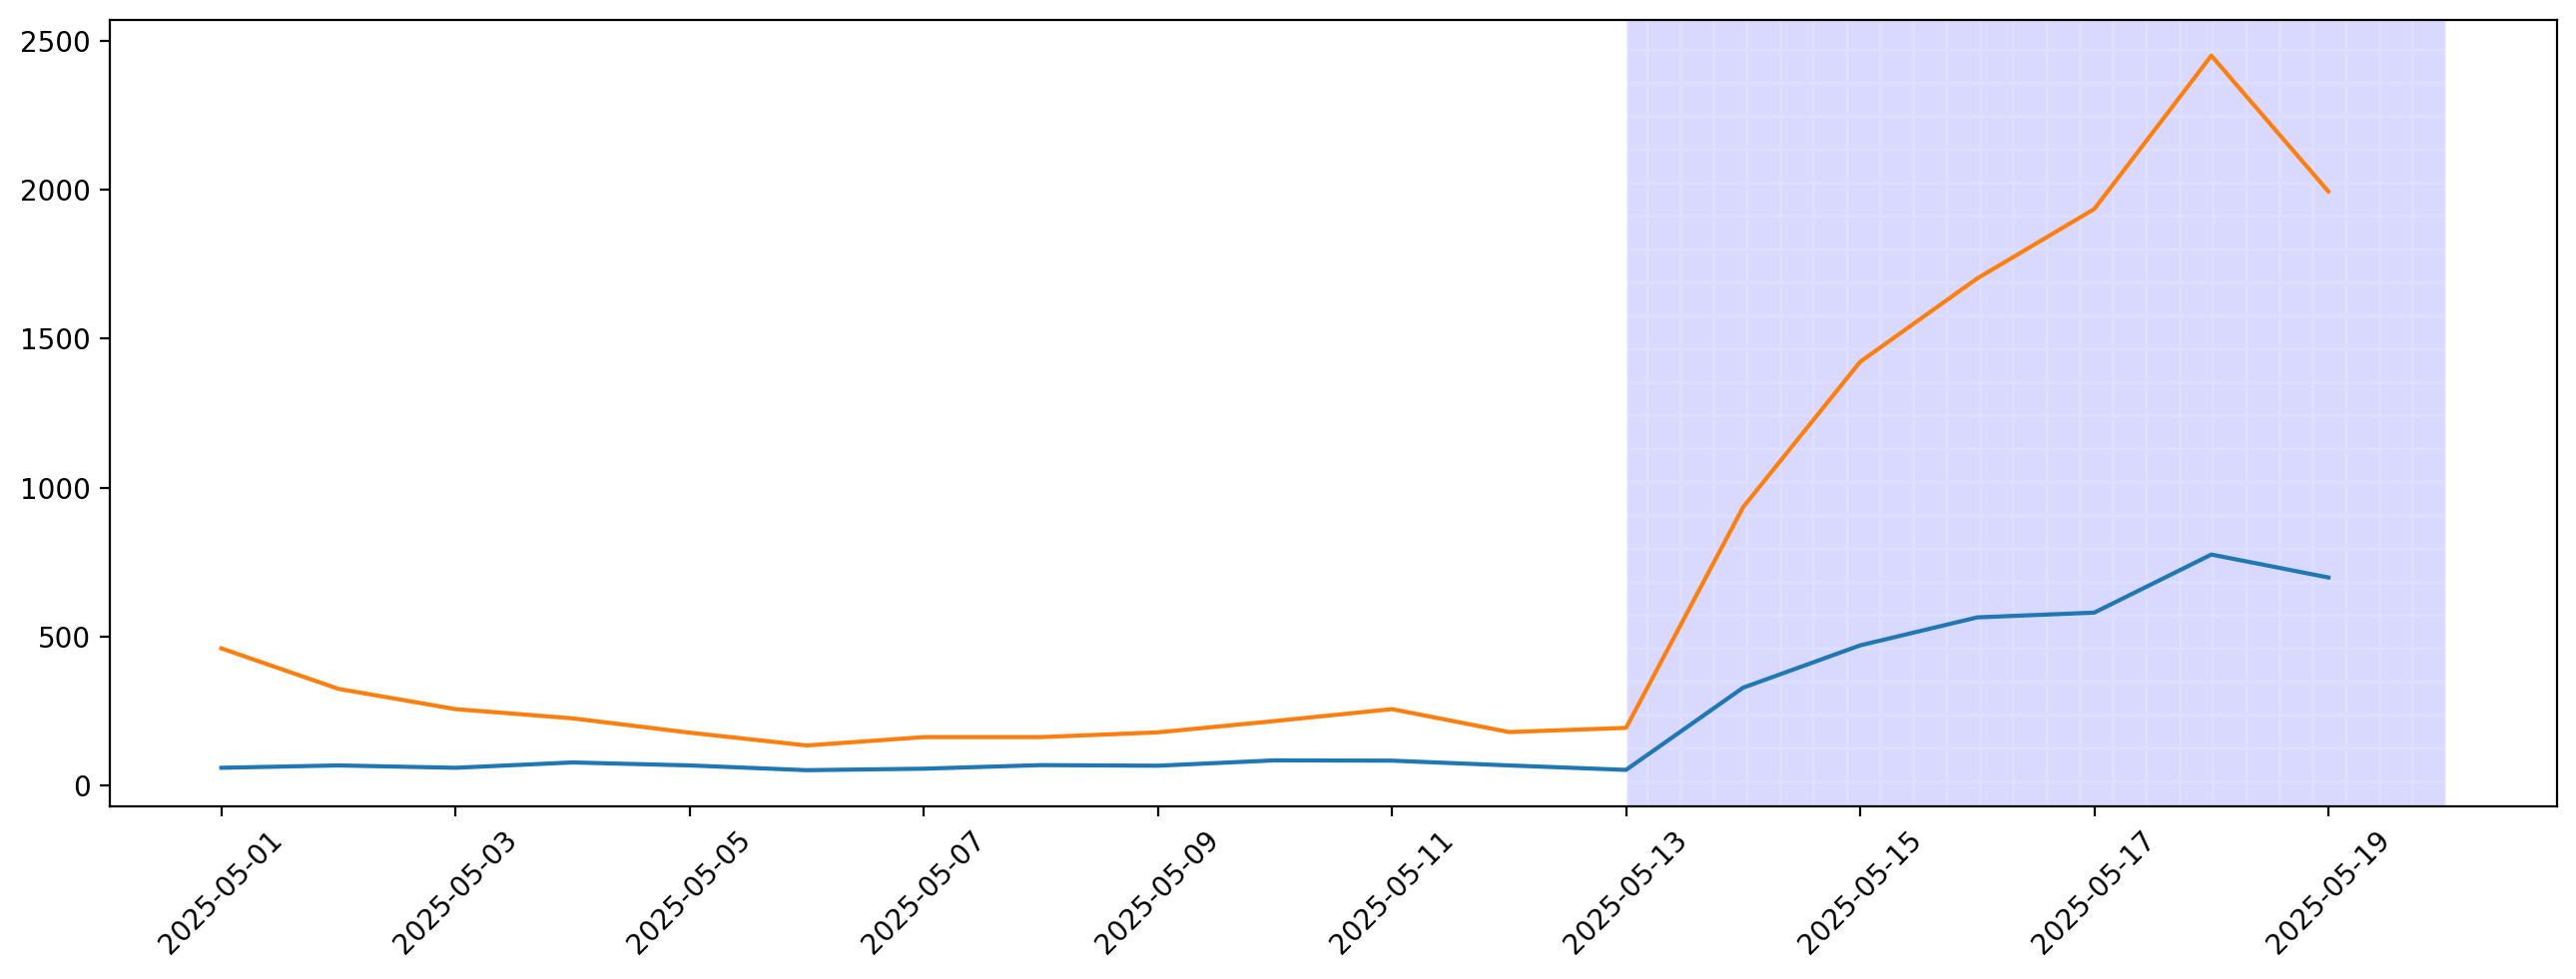

In [68]:

plt.figure(figsize=(13, 5))
plt.plot(df_graph.query("event_dt_part>='2025-05-01' and os_name == 'ios' and status == 'pending'").groupby(['event_dt_part'], as_index=False)['users'].sum()['event_dt_part'], df_graph.query("event_dt_part>='2025-05-01' and os_name == 'ios' and status == 'pending'").groupby(['event_dt_part'], as_index=False)['users'].sum()['users'])
plt.plot(df_graph.query("event_dt_part>='2025-05-01' and os_name == 'android' and status == 'pending'").groupby(['event_dt_part'], as_index=False)['users'].sum()['event_dt_part'], df_graph.query("event_dt_part>='2025-05-01' and os_name == 'android' and status == 'pending'").groupby(['event_dt_part'], as_index=False)['users'].sum()['users'])
# date_format = mdates.DateFormatter('%Y-%m-%d')
# ax.xaxis.set_major_formatter(date_format)

plt.xticks(rotation=45) 
plt.tight_layout()

plt.axvspan(datetime(2025, 5, 13), datetime(2025, 5, 20), facecolor='blue', alpha=0.15, hatch='+', edgecolor='white', linewidth=1)

plt.show()



In [11]:
df = read_bq("""
SELECT user_id,
       os_name,
       city_id,
       city_name,
       country_id,
       country_name,
       COALESCE(filled_flow, 'liveness')                                  AS filled_flow,
       COALESCE(MAX(IF(name = 'client.verification_start.show', TIMESTAMP_ADD(
               TIMESTAMP_TRUNC(client_time, HOUR),
               INTERVAL
               CAST(FLOOR(EXTRACT(MINUTE FROM client_time) /
                          30) *
                    30 AS INT64) MINUTE
                                                                ), NULL)),
                MAX(IF((name = 'client.verification_flow_result_status.show' AND
                        LOWER(status) = 'approve'), TIMESTAMP_ADD(
                               TIMESTAMP_TRUNC(client_time, HOUR),
                               INTERVAL
                               CAST(FLOOR(EXTRACT(MINUTE FROM client_time) /
                                          30) *
                                    30 AS INT64) MINUTE
                                                    ), NULL)),
                MAX(IF((name = 'client.verification_flow_result_status.show' AND
                        LOWER(status) != 'approve'), TIMESTAMP_ADD(
                               TIMESTAMP_TRUNC(client_time, HOUR),
                               INTERVAL
                               CAST(FLOOR(EXTRACT(MINUTE FROM client_time) /
                                          30) *
                                    30 AS INT64) MINUTE
                                                     ), NULL)))           AS show_dt,
       COALESCE(MAX(IF(name = 'client.verification_start.click', client_time, NULL)),
                MAX(IF((name = 'client.verification_flow_result_status.show' AND
                        LOWER(status) = 'approve'), client_time, NULL)),
                MAX(IF((name = 'client.verification_flow_result_status.show' AND
                        LOWER(status) != 'approve'), client_time, NULL))) AS click_dt,
       MAX(IF((name = 'client.verification_flow_result_status.show' AND
               LOWER(status) = 'approve'), client_time, NULL))            AS approve_dt,
       MAX(IF((name = 'client.verification_flow_result_status.show' AND
               LOWER(status) != 'approve'), client_time, NULL))           AS not_approve_dt
FROM (SELECT t1.user_id,
             t1.name,
             t1.os_name,
             DATE(TIMESTAMP_MILLIS(t1.client_time))                  AS event_dt_part,
             TIMESTAMP_MILLIS(t1.client_time)                        AS client_time,
             t1.city_id,
             t2.city_name,
             t2.country_id,
             t2.country_name,
             JSON_EXTRACT_SCALAR(payload, '$.verification_flow')     AS verification_flow,
             IF(JSON_EXTRACT_SCALAR(payload, '$.verification_flow') IS NULL,
                LAG(JSON_EXTRACT_SCALAR(payload, '$.verification_flow'))
                    OVER (PARTITION BY t1.user_id ORDER BY client_time),
                JSON_EXTRACT_SCALAR(payload, '$.verification_flow')) AS filled_flow,
             JSON_EXTRACT_SCALAR(payload, '$.status')                AS status
      FROM (SELECT *
            FROM indriver-e6e40.emart.product_event t1
            WHERE 1 = 1
              AND name IN (
                           'client.verification_start.show',
                           'client.verification_start.click',
                           'client.verification_flow_result_status.show'
                )
              AND event_dt_part BETWEEN '2025-05-18' AND '2025-05-21'
              AND DATE(TIMESTAMP_MILLIS(t1.client_time)) BETWEEN '2025-05-18' AND '2025-05-21'
              AND country_id IN (11)
            QUALIFY
                ROW_NUMBER() OVER (PARTITION BY user_id, name, os_name, event_dt_part, JSON_EXTRACT_SCALAR(payload, '$.verification_flow') ORDER BY client_time DESC) =
                1) t1
               JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
                    ON
                        t1.city_id = t2.city_id
      WHERE 1 = 1
        AND name IN (
                     'client.verification_start.show', 'client.verification_start.click',
                     'client.verification_flow_result_status.show'
          ))
        -- AND EXTRACT(HOUR FROM TIMESTAMP_MILLIS(t1.client_time)) IN (10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20))
GROUP BY 1, 2, 3, 4, 5, 6, 7
""")

df.head()

,user_id,os_name,city_id,city_name,country_id,country_name,filled_flow,show_dt,click_dt,approve_dt,not_approve_dt
0,197510270,ios,4536,Cuiabá,11,Brazil,documents,2025-05-21 03:00:00+00:00,2025-05-21 03:10:51.263000+00:00,2025-05-21 03:11:06.570000+00:00,NaT
1,198809005,ios,4556,Chapecó,11,Brazil,documents,2025-05-19 23:30:00+00:00,NaT,NaT,NaT
2,295798802,android,4161,Joinville,11,Brazil,documents,2025-05-18 04:00:00+00:00,2025-05-18 04:23:51.609000+00:00,2025-05-18 04:24:06.806000+00:00,NaT
3,296146100,android,4536,Cuiabá,11,Brazil,documents,2025-05-19 11:00:00+00:00,2025-05-19 11:04:46.633000+00:00,2025-05-19 11:05:30.761000+00:00,NaT
4,231246413,ios,4758,Santos,11,Brazil,liveness,2025-05-20 16:30:00+00:00,2025-05-20 16:34:13.796000+00:00,2025-05-20 16:34:46.824000+00:00,NaT


In [12]:
df['approve_flag'] = df['approve_dt'].apply(lambda x: 0 if pd.isna(x) else 1)
df['not_approve_flag'] = df['not_approve_dt'].apply(lambda x: 0 if pd.isna(x) else 1)


In [27]:
fig = px.line(df.groupby(['show_dt', 'os_name'],as_index=False)[['not_approve_flag', 'approve_flag']].sum(), x="show_dt", y="approve_flag", color='os_name')
fig.add_vrect(
    x0="2025-05-20 13:30:00+00:00", 
    x1="2025-05-20 17:30:00+00:00",
    fillcolor="yellow", 
    opacity=0.4, 
    layer="below", 
    line_width=0
)

fig.add_vrect(
    x0="2025-05-20 10:30:00+00:00", 
    x1="2025-05-20 13:30:00+00:00",
    fillcolor="lightgreen", 
    opacity=0.2, 
    layer="below", 
    line_width=0
)

fig.add_vrect(
    x0="2025-05-20 17:30:00+00:00", 
    x1="2025-05-20 20:30:00+00:00",
    fillcolor="lightgreen", 
    opacity=0.2, 
    layer="below", 
    line_width=0
)

fig.show()